## HW#2 Supervised Learning I

In this assignment, you are going to practice supervised learning ML modelings. 

**DUE: 10/12/2020 Thursday 11:59 PM.**

### Problem #1 Linear Regression (20 pts)
Data: Bike Sharing Dataset

#### Data Set
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

#### Files
- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

#### Dataset Characteristics:
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    
#### Task
- Predict the count of total rental bikes including both casual and registered.
- Test Set: Daily Basis - August, Hourly Basis - Summer Season (June, July, and August from 10 AM to 2 PM)

a) (2 pts) Split the datasets into train and test sets. (do for both)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import ndarray
from sklearn.linear_model import LinearRegression

In [3]:
day = pd.read_csv('day.csv', index_col=0)
hour = pd.read_csv('hour.csv', index_col=0)

print("Separating day dataset into train and test set with month of August being the test.")
day_train = day.loc[day['mnth'] != 8]
day_test = day.loc[day['mnth'] == 8]

assert (day_train.shape[0] + day_test.shape[0]) == day.shape[0]  # Make sure we capture all the data

print("Separating hour dataset into train & test set with June, July, and August from 10 AM to 2 PM being " \
      "the test.")
hour_test = hour.loc[((hour['mnth'] >= 6) & (hour['mnth'] <= 8) & (hour['hr'] >= 10) & (hour['hr'] <= 14))]
hour_train = hour.loc[
    (((hour['mnth'] < 6) | (hour['mnth'] > 8)) | 
    (((hour['mnth'] >= 6) & (hour['mnth'] <= 8) & (hour['hr'] < 10) | (hour['hr'] > 14))))
]

assert (hour_train.shape[0] + hour_test.shape[0]) == hour.shape[0] # Make sure we capture all the data

Separating day dataset into train and test set with month of August being the test.
Separating hour dataset into train & test set with June, July, and August from 10 AM to 2 PM being the test.


b) (2 pts) Before you do anything with the train datasets, which features can be deleted? Explain why. (do for both)

## Answer

> The columns `dteday` and `yr` can be deleted because they are cyclical and will not add any additional contextual data to training and testing sets. 
- Since the necessary descriptors from the day have already been extracted (e.g. `temp`, `atemp`, `hum`, `workingday` and others), the actual date is not necessary. Moreover, a simple date will likely not influence a decision to rent a bike.
- The specific year will likely not have any influence on whether or not a person rents a bike. Concretely, a person is not likely to decide to rent a bike simply because it is 2012. Hence, this can be removed.

> The column `mnth` can be removed because it has already been encoded as the `season` column.

> Maybe: `holiday`, `weekday` because they are encapsulated in other columns, but I will leave them in for further correlative testing.

In [4]:
to_drop = ['dteday', 'yr', 'mnth']
day_train = day_train.drop(labels=to_drop, axis=1)
day_test = day_test.drop(labels=to_drop, axis=1)

hour_train = hour_train.drop(labels=to_drop, axis=1)
hour_test = hour_test.drop(labels=to_drop, axis=1)

day_test

season  holiday  weekday  workingday  weathersit      temp     atemp  \
instant                                                                         
213           3        0        1           1           1  0.771667  0.703292   
214           3        0        2           1           1  0.783333  0.707071   
215           3        0        3           1           2  0.731667  0.679937   
216           3        0        4           1           2  0.710000  0.664788   
217           3        0        5           1           1  0.710833  0.656567   
...         ...      ...      ...         ...         ...       ...       ...   
605           3        0        1           1           1  0.703333  0.654688   
606           3        0        2           1           1  0.728333  0.666050   
607           3        0        3           1           1  0.685000  0.635733   
608           3        0        4           1           1  0.706667  0.652779   
609           3        0        5           1           1  0.764167  0.689400   

              hum  windspeed  casual  registered   cnt  
instant                                                 
213      0.550833   0.156717     729        3537  4266  
214      0.491250   0.205850     801        4044  4845  
215      0.657500   0.135583     467        3107  3574  
216      0.757500   0.197150     799        3777  4576  
217      0.630833   0.184696    1023        3843  4866  
...           ...        ...     ...         ...   ...  
605      0.730417   0.128733     989        5928  6917  
606      0.620000   0.190925     935        6105  7040  
607      0.552083   0.112562    1177        6520  7697  
608      0.590417   0.077117    1172        6541  7713  
609      0.587500   0.168533    1433        5917  7350  

[62 rows x 12 columns]

c) (2 pts) Make `weathersit` and `weekday` one-hot vectors. (do for both)
- Do you think this process is necessary? Do you find other features that are necessary to do this? Explain why. If you find any features that are needed to be tranformed into one-hot vectors, please do. 
- **Do not** do on the test sets here as well as step d).  

## Answer
> Yes, the one-hot encoding process is necessary because, otherwise, the model may assume that one category is more statistically significant than the other simply by its number. Concretely, this means that the model may weight something like Thursday (4) more Monday (1) (e.g. the mean would be 1 + 4 / 2 = 2.5, which weighs more heavily toward Thursday).
- The other categories that are necessary to one-hot encode are `season` and `hr` (for the hourly data).

In [5]:
### Code Starts Here ###

encoding = dict(
    weathersit=dict(is_clear=1, is_cloudy=2, is_rainy=3),
    weekday=dict(sun=0, mon=1, tues=2, wed=3, thur=4, fri=5),
    season=dict(spring=1, summer=2, fall=3),
    hr=dict(morning=[6,7,8,9,10,11], afternoon=[12,13,14,15,16,17,18,19,20])
)


def one_hot(col: str, mapping: dict, df: pd.DataFrame) -> pd.DataFrame:
    """ One hot encodes a column "col" in a pandas DataFrame using the categories passed like 
    
        {
            "encode_col": "current_value"
        }
        
        The old categorical column will also be dropped from the data frame
    """
    
    df_copy = df.copy()
    for k, v in mapping.items():
        if isinstance(mapping[k], list):
            df[k] = df.apply(lambda x: int(x[col] in mapping[k]), axis=1)
        else:
            df[k] = df.apply(lambda x: int(x[col] == mapping[k]), axis=1)
    return df.drop(col, axis=1)


for col, mapping in encoding.items():
    print(f"One hot encoding {col}")
    if col in day_train.columns:
        day_train = one_hot(col, mapping, day_train)
    if col in hour_train.columns:
        hour_train = one_hot(col, mapping, hour_train)

day_train

One hot encoding weathersit
One hot encoding weekday
One hot encoding season
One hot encoding hr


holiday  workingday      temp     atemp       hum  windspeed  casual  \
instant                                                                         
1              0           0  0.344167  0.363625  0.805833   0.160446     331   
2              0           0  0.363478  0.353739  0.696087   0.248539     131   
3              0           1  0.196364  0.189405  0.437273   0.248309     120   
4              0           1  0.200000  0.212122  0.590435   0.160296     108   
5              0           1  0.226957  0.229270  0.436957   0.186900      82   
...          ...         ...       ...       ...       ...        ...     ...   
727            0           1  0.254167  0.226642  0.652917   0.350133     247   
728            0           1  0.253333  0.255046  0.590000   0.155471     644   
729            0           0  0.253333  0.242400  0.752917   0.124383     159   
730            0           0  0.255833  0.231700  0.483333   0.350754     364   
731            0           1  0.215833  0.223487  0.577500   0.154846     439   

         registered   cnt  is_clear  ...  is_rainy  sun  mon  tues  wed  thur  \
instant                              ...                                        
1               654   985         0  ...         0    0    0     0    0     0   
2               670   801         0  ...         0    1    0     0    0     0   
3              1229  1349         1  ...         0    0    1     0    0     0   
4              1454  1562         1  ...         0    0    0     1    0     0   
5              1518  1600         1  ...         0    0    0     0    1     0   
...             ...   ...       ...  ...       ...  ...  ...   ...  ...   ...   
727            1867  2114         0  ...         0    0    0     0    0     1   
728            2451  3095         0  ...         0    0    0     0    0     0   
729            1182  1341         0  ...         0    0    0     0    0     0   
730            1432  1796         1  ...         0    1    0     0    0     0   
731            2290  2729         0  ...         0    0    1     0    0     0   

         fri  spring  summer  fall  
instant                             
1          0       1       0     0  
2          0       1       0     0  
3          0       1       0     0  
4          0       1       0     0  
5          0       1       0     0  
...      ...     ...     ...   ...  
727        0       1       0     0  
728        1       1       0     0  
729        0       1       0     0  
730        0       1       0     0  
731        0       1       0     0  

[669 rows x 21 columns]

d) (2 pts) Using the train sets, find the correlation between coorelations between features and target variable. 
   - Did you find other features that can be deleted? Explain why. 

## Answer

### Both Data Sets

> There are a few more columns that can be deleted from both datasets: `temp`, `workingday`, `weekday`, and `holiday`.

- `workingday`, `holiday`, and `weekday` are not strongly correlated with the `cnt` in either the `hour_train` or `day_train` testing sets, so they can be deleted. 
- `temp` can be deleted because `atemp` and `temp` are describing essentially the same phenomena (as evidenced by the near perfect correlation between the variables). However, `atemp` provides a slightly better correlation with the `cnt` variable, so I am choosing to keep `atemp` over `temp`.

### Hour Train

> The `weathersit` variable can also be deteled because it does not have a good correlation with the `cnt` target variable. 

### Day Train
> For the `day_train` data set, the `hum` variable can be deleted for the same reason.

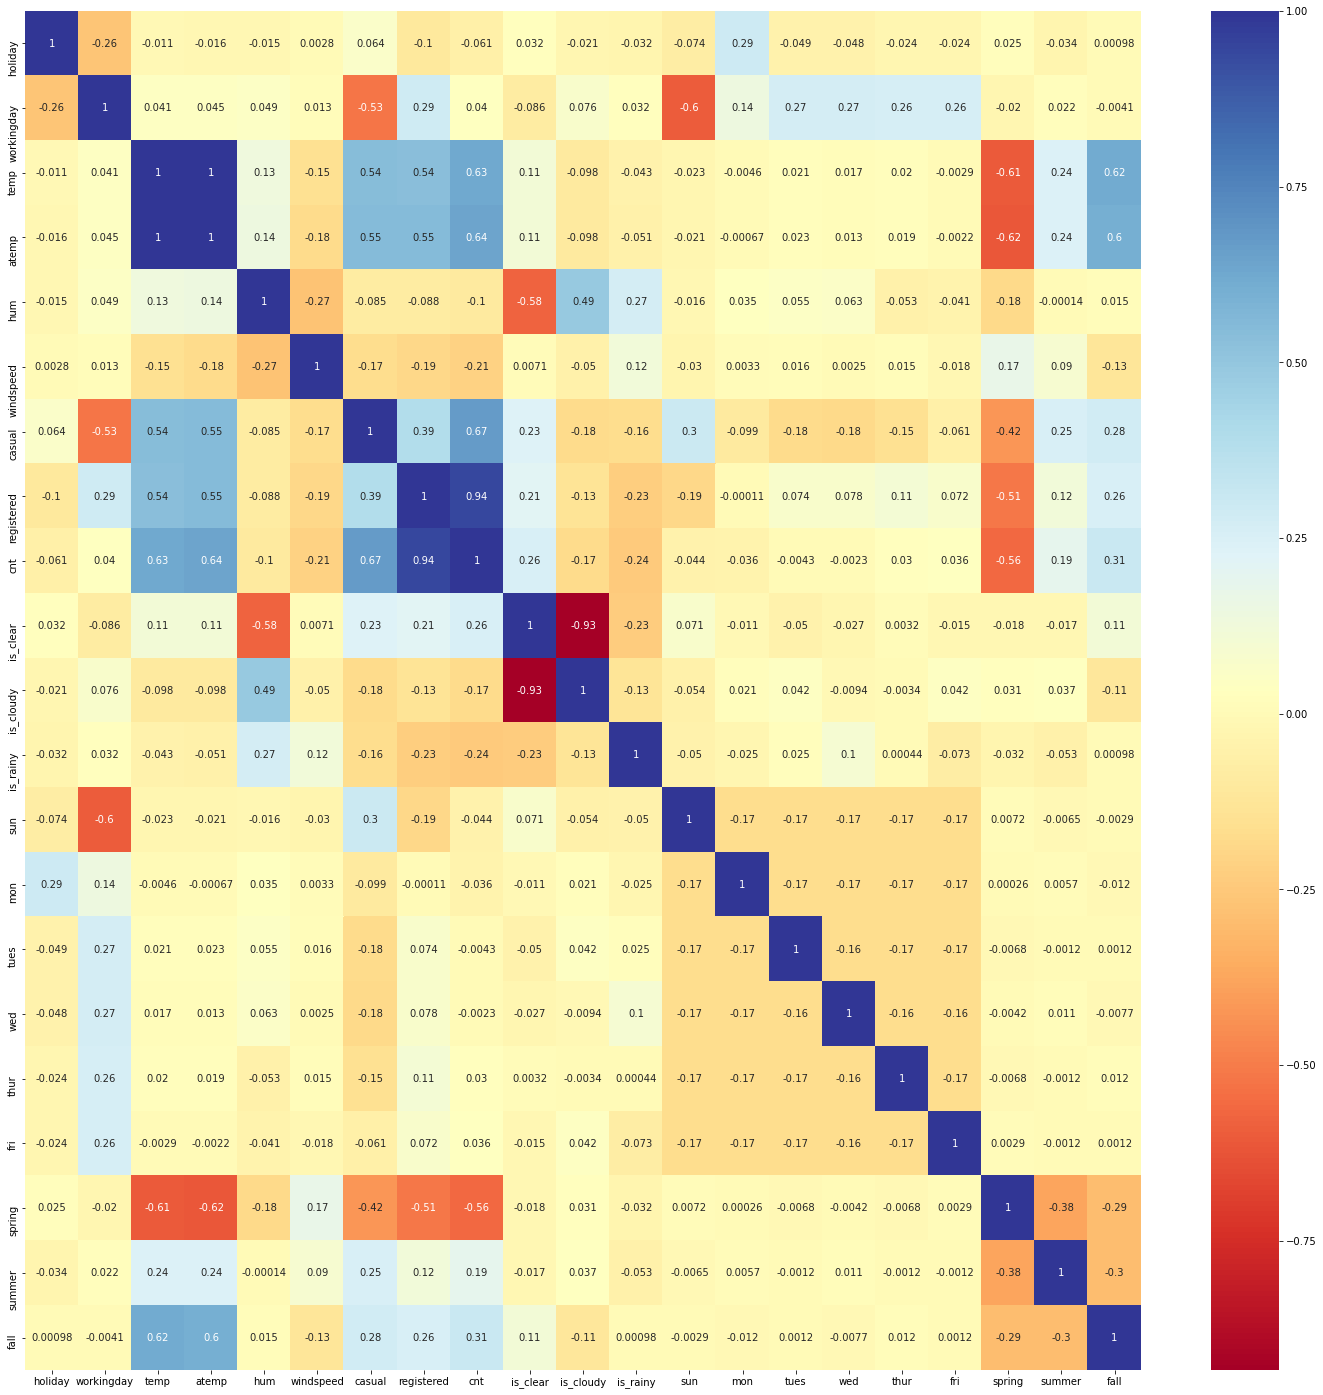

In [6]:
### Code Starts Here ###
day_corr = day_train.corr()
plt.figure(figsize=(25,25))
sns.heatmap(day_corr, annot=True, cmap="RdYlBu")

# Keep: atemp, spring, fall, is_rainy, is_clear,

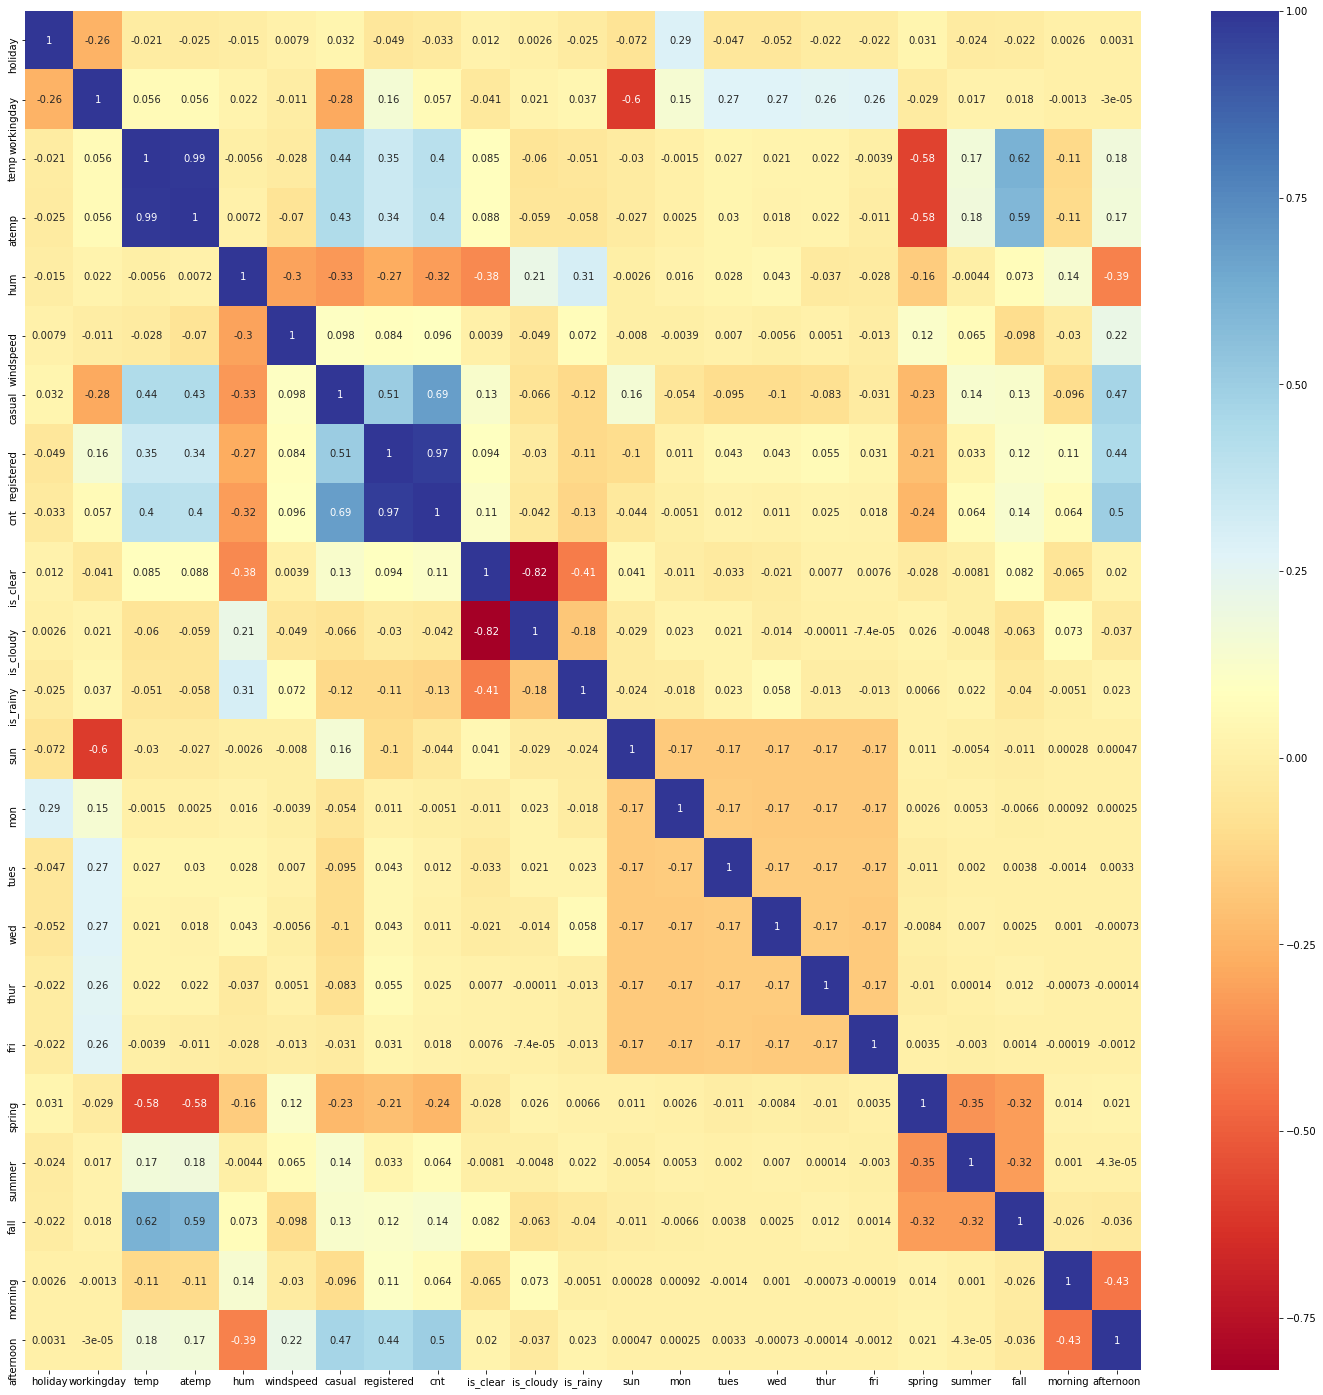

In [7]:
hour_corr = hour_train.corr()
plt.figure(figsize=(25,25))
sns.heatmap(hour_corr, annot=True, cmap="RdYlBu")

# Keep atemp, hum, morning, afternoon, evening, spring, summer, fall

e) (1 pts) Do you think you need to do cross-validation? What is the advantage and disadvantage of doing it?

### Answer Here ###
Yes, I think cross-validation is necessary. Cross-validation is necessary because it helps to ensure that the model is not picking up on noise; rather it is reflecting the actual trends in the data set. 
- The advantage is that we get a real-time capture of how well our model performs on "new" data. 
- The downside is that it removes some of the training data and it may result is less general model. 

f) (7 pts) Using `LinearRegression` from `sklearn` and `polyfit` from `numpy`, train two models each by having all features and 5 features based on step a) thru d). You might have to train polynomial model multiple times and you may go back do futher feature engineerings. **If you do, please show all work. Do not erase any work.** (do for both)

In [8]:
### Code Starts Here ###
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def polyfit(X: pd.DataFrame, y: pd.DataFrame):
    """ Uses numpy's polyfit to train the model """
    model = []
    y = np.array(y)
    y = y.reshape(y.shape[0])
    for label, col in X.iteritems():
        x = np.array(col)
        m = np.polyfit(x, y, 1)
        model.append(m)
    return np.array(model)

def sklinear(X: pd.DataFrame, y: pd.DataFrame):
    """ Uses sklearn LinearRegression to train the model """
    polyreg = Pipeline([('poly', PolynomialFeatures(degree=1)), ('model', LinearRegression())])
    return polyreg.fit(X, y)

hour_features = ['atemp', 'hum', 'is_clear', 'afternoon', 'spring']
day_features = ['atemp', 'spring', 'fall', 'is_rainy', 'is_clear']
not_features = ['cnt', 'casual', 'registered']

### Day
X_day = day_train.loc[:, day_features]
X_all_day = day_train.loc[:, [col for col in day_train.columns if col not in not_features]]
y_day = day_train.loc[:, ['cnt']]

skday = sklinear(X_day, y_day)
all_skday = sklinear(X_all_day, y_day)

polyday = polyfit(X_day, y_day)
all_polyday = polyfit(X_all_day, y_day)


### Hour
X_hour = hour_train.loc[:, hour_features]
X_all_hour = hour_train.loc[:, [col for col in hour_train.columns if col not in not_features]]
y_hour = hour_train.loc[:, ['cnt']]

skhour = sklinear(X_hour, y_hour)
all_skhour = sklinear(X_all_hour, y_hour)

polyhour = polyfit(X_hour, y_hour)
all_polyhour = polyfit(X_all_hour, y_hour)

g) (2 pts) Report value of coefficent ${\bf w}$, **RMSE**, and **$R^2$** of all models. Which model is the best? Explain why. (asnwer for both data sets)

In [9]:
### Code Starts Here ###
from sklearn import metrics

def polypredict(model, X: pd.DataFrame) -> ndarray:
    """ Gets the predictions for the model """
    n = X.shape[0]
    stack = None
    for idx, m in enumerate(model):
        data = np.array(X[X.columns[idx]])
        predict = np.poly1d(m)(data).reshape(n, 1)
        if stack is None:
            stack = predict
        else:
            stack = np.hstack((stack,predict))
    return np.mean(stack, axis=1)


def polyreport(name: str, model: ndarray, X: pd.DataFrame, y: pd.DataFrame) -> None:
    """ Reports the coefficients, Root Mean Squared Error, and the R^2 for the polyfit model """
    intercept = np.mean(model, axis=0)[1]
    coef = np.array([*np.delete(model, 1, 1).reshape(model.shape[0]), intercept])
    y_pred = polypredict(model, X)
    report(name, coef, y_pred, y)

    
def skreport(name: str, model: LinearRegression, X: pd.DataFrame, y: pd.DataFrame) -> None:
    """ Reports the coefficients, Root Mean Squared Error, and the R^2 for Sklearn's LinearRegression model """
    coef = model.named_steps.model.coef_
    y_pred = model.predict(X)
    report(name, coef, y_pred, y)
    

def report(name: str, coef: ndarray, y_pred: ndarray, y: ndarray):
    print(f"================================= {name.upper()} Results ============================================")
    print(f"Coefficients are as follows: {coef}")
    rsme = metrics.mean_squared_error(y, y_pred)
    r_2 = metrics.r2_score(y, y_pred)
    print(f"The RSME for the model is {rsme} and the R^2 score is {r_2}")
    print("================================= END Results ============================================\n\n")

model_name = ("day", "all_day", "hour", "all_hour")
skreport("skday", skday, X_day, y_day)
polyreport("polyday", polyday, X_day, y_day)

skreport("all skday", all_skday, X_all_day, y_day)
polyreport("all polyday", all_polyday, X_all_day, y_day)

skreport("skhour", skhour, X_hour, y_hour)
polyreport("polyhour", polyhour, X_hour, y_hour)

skreport("all skhour", all_skhour, X_all_hour, y_hour)
polyreport("all skhour", all_polyhour, X_all_hour, y_hour)


================================= SKDAY Results ============================================
Coefficients are as follows: [[    0.          5833.96304    -1295.21277396  -432.29026376
  -2095.17359561   645.3305205 ]]
The RSME for the model is 1752541.4095851113 and the R^2 score is 0.5332820355337595
================================= END Results ============================================


================================= POLYDAY Results ============================================
Coefficients are as follows: [ 7752.88503362 -2457.62355086  1524.73625362 -2677.6031746
  1025.81792886  3650.32588308]
The RSME for the model is 2612566.8290414354 and the R^2 score is 0.30424932283289197
================================= END Results ============================================


================================= ALL SKDAY Results ============================================
Coefficients are as follows: [[ 0.00000000e+00  3.36542417e+15  3.36542417e+15 -7.91500000e+02
   7.84581250e+03

## Best models 
- The best model for the `day` dataset is the `ALL SKDAY` model because it has the highest R^2 value (i.e. it explains most of the data set)
- The best model for the `hour` dataset is the `ALL SKHOUR` model for the same reason above.

h) (2 pts) Using the best model out of 4 models, evaluate the model using the test sets. Can you use a model from daily data to hourly test set? Explain why or why not. 

## Answer 
> You cannot use a model from the daily data to test the hourly data because:
1. They provide different data,
2. The models have different features, and
3. The data is geared toward a different measurement (one for the entire day, and one for the hour).

> These are not very well done models - they score quite poorly when presented with new data.

In [10]:
### Code Starts Here ###
best_day = all_skday
best_hour = all_skhour


for col, mapping in encoding.items():
    if col in day_test.columns:
        day_test = one_hot(col, mapping, day_test)
    if col in hour_test.columns:
        hour_test = one_hot(col, mapping, hour_test)
        
not_features = ['cnt', 'casual', 'registered']
xday = day_test.loc[:, [col for col in day_test.columns if col not in not_features]]
yday = day_test.loc[:, ['cnt']]

xhour = hour_test.loc[:, [col for col in hour_test.columns if col not in not_features]]
yhour = hour_test.loc[:, ['cnt']]

print(f"Best model for day scores: {best_day.score(xday, yday)}")
print(f"Best model for hour scores: {best_hour.score(xhour, yhour)}")

Best model for day scores: 0.011320634607592361
Best model for hour scores: -0.7910931107503225


### Problem 2 - Non-probabilitistc Classifications (Lecture 3 and 4) (32 pts)
Dataset: Iris Data - find here: https://archive.ics.uci.edu/ml/datasets/iris

In [11]:
# Loading the IRIS code (like in the demonstration HTML)
from sklearn import datasets
iris = datasets.load_iris()
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

a) (8 pts) Implement KNN algorithm, call it `myKNN`. You are welcome to use `numpy` for implementation but nothing else. 

In [12]:
### Code Starts Here ###
import math
from collections.abc import Iterable

class myKNN:
    """ Implements the k-nearest neighbor algorithm """
    
    def __init__(self, k: int, p: int):
        """ Initializes the class with the number of neighbors and the p """
        if k == 0 or p == 0:
            raise ValueError("K must be above 0 and p must be either 1 or 2")
        self.k = k
        self.p = p
        self.data = None
        self.labels = None

    def fit(self, X: ndarray, y: ndarray) -> None:
        """ Initializes the data """
        data = self._create_nparray(X)
        labels = self._create_nparray(y)
        if data.shape[0] != labels.shape[0]:
            raise ValueError("Data and targets must have same number of rows")

        ex1 = self._create_nparray(data[0])            
        if len(ex1.shape) != 1:
            raise ValueError("Data examples should only be one dimensional")
            
        self.data = data
        self.labels = labels
        
    def score(self, X: ndarray, y: ndarray) -> float:
        """ Scores how well the KNN predicts """
        correct = 0.0
        for idx, x in enumerate(X):
            label = self.predict(x)
            correct += int(label == y[idx])
        return correct / len(y)
            
    def predict(self, tests: ndarray) -> ndarray:
        """ Predicts the target value based on the initialized data """
        if self.data is None or tests is None or len(tests) == 0:
            raise ValueError("Not sufficient data to predict")
        
        if len(tests.shape) == 1:
            return self._predict(tests)
        
        classes = []
        for t in tests:
            classes.append(self._predict(t))
        return np.array(classes)

    def _predict(self, test: ndarray) -> ndarray:
        """ Makes a prediction for a single test case """
        test = self._create_nparray(test)
        neighbors = self._k_neighbors(test)  # Get nearest neighbors
        labels = [self.labels[i] for i, v in neighbors]  # Get the labels for the neighbors
        return self._mode(labels)  # Get the most common class
        
    def _k_neighbors(self, target: ndarray) -> list:
        """ Gets the k nearest neighbors from the test point """
        neighbors = list()
        for idx, d in enumerate(self.data):
            d = self._create_nparray(d)
            if target.shape != d.shape:
                raise ValueError(f"Shapes of test data {target} does not match initialized data {d}")
                
            dist = self._distance(d, target)
            neighbors.append((idx, dist)) 
        return sorted(neighbors, key=lambda x: x[1])[:self.k]

    def _distance(self, x: ndarray, y: ndarray):
        """ Calculates the distnace between two points """
        total = np.power(abs(x - y), self.p)
        if isinstance(total, ndarray):
            total = sum(total)
        return np.power(total, 1/self.p)
    
    @staticmethod
    def _mode(labels: list):
        """ Returns the mode given a list of items 
            Fast one-line solution from: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
        """        
        return max(set(labels), key=labels.count)
    
    @staticmethod
    def _create_nparray(x) -> ndarray:
        """ Creates a numpy array from a piece of data """
        if not isinstance(x, np.ndarray):
            if not isinstance(x, Iterable):
                x = np.array([x])
            else:
                x = np.array(x)
        return x
        

b)(4 pts) Without splitting the dataset, classify the names using `myKNN` from $k=1$ to $25$. Then report the accuracy of `myKNN` for each $k$ value. You are free to extend the range of $k$ values up to $50$. 

In [13]:
### Code Starts Here ###
my_x = []
my_y = []

for i in range(1, 51):
    knn = myKNN(k=i, p=2)
    knn.fit(iris.data, iris.target)
    score = knn.score(iris.data, iris.target)
    my_x.append(i)
    my_y.append(score)
    print(f"myKNN scored {score * 100}% for a K of {i}")

myKNN scored 100.0% for a K of 1
myKNN scored 98.0% for a K of 2
myKNN scored 96.0% for a K of 3
myKNN scored 96.0% for a K of 4
myKNN scored 96.66666666666667% for a K of 5
myKNN scored 97.33333333333334% for a K of 6
myKNN scored 97.33333333333334% for a K of 7
myKNN scored 98.0% for a K of 8
myKNN scored 98.0% for a K of 9
myKNN scored 98.0% for a K of 10
myKNN scored 97.33333333333334% for a K of 11
myKNN scored 98.0% for a K of 12
myKNN scored 98.0% for a K of 13
myKNN scored 98.0% for a K of 14
myKNN scored 98.66666666666667% for a K of 15
myKNN scored 98.66666666666667% for a K of 16
myKNN scored 98.0% for a K of 17
myKNN scored 97.33333333333334% for a K of 18
myKNN scored 98.0% for a K of 19
myKNN scored 98.0% for a K of 20
myKNN scored 98.0% for a K of 21
myKNN scored 98.0% for a K of 22
myKNN scored 98.0% for a K of 23
myKNN scored 97.33333333333334% for a K of 24
myKNN scored 98.0% for a K of 25
myKNN scored 97.33333333333334% for a K of 26
myKNN scored 97.33333333333334% f

c) (2 pts) Do the same as b) using `sklearn.neighbors`. 

In [14]:
### Code Starts Here ###
from sklearn.neighbors import KNeighborsClassifier

In [15]:
sk_x = []
sk_y = []
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='minkowski')
    knn.fit(iris.data, iris.target)
    score = knn.score(iris.data, iris.target)
    sk_x.append(i)
    sk_y.append(score)
    print(f"KNeighborsClassifier scored {score * 100}% for a K of {i}")

KNeighborsClassifier scored 100.0% for a K of 1
KNeighborsClassifier scored 98.0% for a K of 2
KNeighborsClassifier scored 96.0% for a K of 3
KNeighborsClassifier scored 96.0% for a K of 4
KNeighborsClassifier scored 96.66666666666667% for a K of 5
KNeighborsClassifier scored 97.33333333333334% for a K of 6
KNeighborsClassifier scored 97.33333333333334% for a K of 7
KNeighborsClassifier scored 98.0% for a K of 8
KNeighborsClassifier scored 98.0% for a K of 9
KNeighborsClassifier scored 98.0% for a K of 10
KNeighborsClassifier scored 97.33333333333334% for a K of 11
KNeighborsClassifier scored 98.0% for a K of 12
KNeighborsClassifier scored 98.0% for a K of 13
KNeighborsClassifier scored 98.0% for a K of 14
KNeighborsClassifier scored 98.66666666666667% for a K of 15
KNeighborsClassifier scored 98.66666666666667% for a K of 16
KNeighborsClassifier scored 98.0% for a K of 17
KNeighborsClassifier scored 97.33333333333334% for a K of 18
KNeighborsClassifier scored 98.0% for a K of 19
KNeig

d) (2 pts) Make a visual presentation of results from b) and c). You can simply make a accuracy vs. $k$ plot. Report the best $k$ value for both. Did you expect the results to be the same? Explain why or why not. 

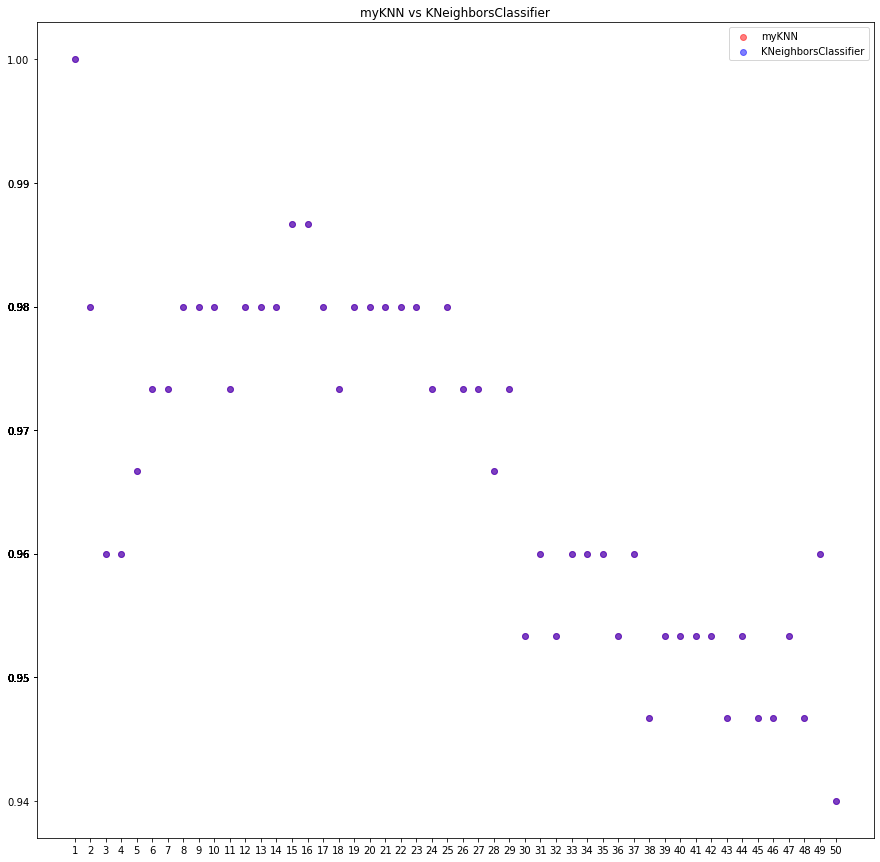

In [16]:
### Code Starts Here ###
plt.figure(figsize=(15,15))
plt.scatter(my_x, my_y,  color="red", alpha=0.5)
plt.scatter(sk_x, sk_y, color="blue",alpha=0.5)
plt.xticks(sk_x)
plt.yticks([round(y, 2) for y in sk_y])
plt.legend(["myKNN", "KNeighborsClassifier"])
plt.title("myKNN vs KNeighborsClassifier")
plt.show()

## Results 

- As you can see from the chart above, the best `k` is 1.
- Yes, I expected the results to be the same for the same `k` because it is implementing the same algorithm.
- Note that the purple color reflects that the `KNeighborsClassifier` and `myKNN` are reporting the same results

e) (6 pts) Implement Linear Discriminant Analysis (call it `myLDA`) for each pair of the classes and report your results.

In [17]:
### Code Starts Here ###
from matplotlib.colors import ListedColormap

class myLDA:
    
    def __init__(self, data: ndarray, labels: ndarray):
        """ Initializes the class """
        self.data = data
        self.labels = labels
        self.features = self.data.shape[1]
        self.cls = set(labels)
        self.mean = np.mean(data, axis=0)
        self.results = None
        
    @property
    def _classes(self) -> dict:
        """ Returns a dictionary of the classes and their values """
        classes = dict()
        for idx, d in enumerate(self.data):
            c = self.labels[idx]
            if classes.get(c) is None:
                classes[c] = np.array([d])
            else:
                classes[c] = np.append(classes[c], [d], axis=0)
        return classes
    
    @property
    def _class_means(self) -> dict:
        class_means = dict()
        for c,v in self._classes.items():
            class_means[c] = np.mean(v, axis=0)
        return class_means
    
    @property
    def _within_class_scatter(self) -> ndarray:
        """ Calculates the scatter matrix within a class """
        scatter = np.zeros((self.features, self.features))
        for idx, d in enumerate(self.data):
            c = self.labels[idx]
            diff = (d - self._class_means[c]).reshape((self.features,1))
            s = np.dot(diff, diff.T)
            scatter += s
        return scatter
    
    @property
    def _btw_class_scatter(self) -> ndarray:
        """ Calculates the scatter matrix between classes """
        scatter = np.zeros((self.features, self.features))
        for k, v in self._class_means.items():
            n = len(self._classes[k])
            mi = self._class_means[k]
            diff = (mi - self.mean).reshape((self.features, 1))
            s = n * np.dot(diff, diff.T)
            scatter += s
        return scatter
    
    def solve(self) -> ndarray:
        """ Solves the LDA alg """
        inv = np.linalg.inv(self._within_class_scatter)
        vals, vec = np.linalg.eig(np.matmul(inv, self._btw_class_scatter))
        transform = self._W(vals, vec)
        self.results = np.matmul(self.data, transform)
        return self.results
    
    def plot(self, labels: bool = True) -> None:
        """ Plots the results (slowly) """
        if self.results is None:
            raise ValueError("Equation has not yet been solved")
        
        if labels:
            color = ('red', 'pink', 'green', 'rocket', 'twilight')
            cmap=ListedColormap(color[:len(self.cls)])
            
            for idx, c in enumerate(self.cls):
                rows = []
                for jdx in range(len(self.results)):
                    cls = self.labels[jdx]
                    if cls == c:
                        rows.append(jdx)
                plt.scatter(self.results[rows, 0], self.results[rows, 1], color=cmap(idx), label=c)
            plt.legend()
                
        else:
            plt.scatter(self.results[:,0], self.results[:,1], alpha=0.6, c=self.labels, cmap='prism')
            
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.show()
            
    
    def _W(self, vals: ndarray, vec: ndarray) -> ndarray:
        """ Computes the transformation matrix of shape d (num features) x k (num classes) """
        concat = [(val, vec[:, idx]) for idx, val in enumerate(vals)]
        concat.sort(key=lambda x: x[0], reverse=True)
        cols = tuple(concat[i][1].reshape((self.features, 1)) for i in range(len(self.cls)))
        return np.hstack(cols).real
    
        
        
lda = myLDA(iris.data, iris.target)
X = lda.solve()

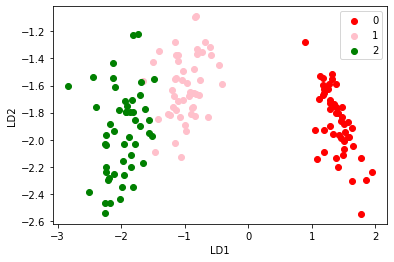

In [18]:
### Code Starts Here ###
lda.plot()

## Results
- Linear separation appears to have been a success

### Problem 3 - Logistic Regression (Lecture 4)
(8 pts) In this problem you are going to built a logistic regression, `myLogistic`. The confirmation of the function will be done in HW#3. 
Here is a brief pseudo code. 

a. Initialize the weight and bias.

b. A sigmoid function

c. Forward/backward Propagation functions $𝑧=𝑥_1𝑤_1+\cdots+𝑥_n𝑤_n+𝑏$

d. Updating Parameters Function

e. Prediction Function

f. Main Function - Logistic Regression

g. Calculate the accuracy

In [27]:
from numpy import ndarray
import numpy as np

class myLogisitic:
    
    def __init__(self, learning_rate: float, precision: float = 0.0001, cutoff: int = 1000):
        """ Initializes the class """
        self.rate = learning_rate
        self.precision = precision
        self.cutoff = cutoff
        self.loss = list()

    def predict(self, X: ndarray) -> ndarray:
        """ Predicts the class of the input array 0 or 1 """
        X = np.insert(X, 0, 1, axis=1)
        Z = self._Z(X)
        return np.argmax(self._posterior(Z), axis=1)
    
    def score(self, X: ndarray, y: ndarray) -> float:
        """ Scores how well the KNN predicts """
        correct = 0.0
        predictions = self.predict(X)
        for idx, label in enumerate(predictions):
            correct += int(label == y[idx])
        return correct / len(y)
    
    def fit(self, X: ndarray, y: ndarray) -> None:
        """ Fits the model to the training data """
        self._bootstrap(X, y)
        for i in range(self.cutoff):
            self._train(X)
            if self.loss[-1] < self.precision:
                break
        self._set_coef()
    
    def _bootstrap(self, X: ndarray, y: ndarray) -> None:
        """ Initializes a random weight and bias for the input data """
        unique = sorted(np.unique(y))
        cls = len(unique)
        self._rand_coef(X, cls)
        self._one_hot(X, y, unique, cls)
    
    def _rand_coef(self, X: ndarray, cls: int) -> None:
        weights = np.random.random(cls)
        bias = np.random.random(cls)
        self.coef_matrix = np.insert(
            np.array([weights] * X.shape[1]), 0, bias, axis=0
        )
        
    def _one_hot(self, X: ndarray, y: ndarray, unique: ndarray, cls: int)-> None:
        """ One hot encodes the targets """
        self.y = np.zeros((X.shape[0], cls))
        for idx, val in enumerate(y):
            cls_idx = unique.index(val)
            self.y[idx][cls_idx] = 1
    
    def _train(self, X: ndarray) -> None:
        """ Train the model one iteration """
        X = np.insert(X, 0, 1, axis=1)
        Z = self._Z(X)
        posteriors = self._posterior(Z)
        self._descend(X, posteriors)
    
    def _Z(self, X: ndarray):
        """ Prepares the data for prediction """
        return np.matmul(X, self.coef_matrix)
        
    def _posterior(self, Z: ndarray) -> ndarray:
        """ Solves the softmax function """
        prob = np.zeros(Z.shape)
        for idx, z in enumerate(Z):
            print(z)
            prob[idx] = np.exp(z) / np.sum(np.exp(z), axis=0)
        return prob
    
    def _descend(self, X: ndarray, posteriors: ndarray) -> None:
        """ Attempts to descend the error function """
        loss = (-1 / X.shape[0]) * np.sum(self.y * np.log(posteriors))
        cost = (-1 / X.shape[0]) * (X.T.dot((self.y - posteriors)))
        self.loss.append(loss)
        self.coef_matrix -= self.rate * cost
    
    def _set_coef(self) -> None:
        """ Sets the coefficients based on the weights and bias """
        self.bias = np.mean(self.coef_matrix[0])
        self.weights = np.mean(np.delete(self.coef_matrix, 0, axis=0), axis=0)
        self.coef_ = np.array([self.bias, *self.weights])



In [28]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data[:, :]  # we only take the first two features.
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape

((100, 4), (100,))

In [29]:
## Example usage
log = myLogisitic(0.05)
log.fit(X_train, y_train)
log.score(X_train, y_train)

[10.93627467  1.41356968  5.64194108]
[14.88744088  1.77812716  7.57530731]
[11.31619449  1.44862328  5.82784168]
[7.9729     1.14015157 4.1919164 ]
[14.81145692  1.77111644  7.53812719]
[10.55635484  1.37851608  5.45604048]
[7.9729     1.14015157 4.1919164 ]
[7.89691604 1.13314085 4.15473628]
[8.73273966 1.21025878 4.5637176 ]
[8.96069156 1.23129094 4.67525796]
[12.15201812  1.52574121  6.236823  ]
[8.04888397 1.14716229 4.22909652]
[7.66896414 1.11210868 4.04319592]
[8.27683587 1.16819445 4.34063688]
[10.70832277  1.39253752  5.53040072]
[7.9729     1.14015157 4.1919164 ]
[10.93627467  1.41356968  5.64194108]
[15.72326451  1.85524509  7.98428863]
[7.36502828 1.0840658  3.89447544]
[11.39217846  1.455634    5.8650218 ]
[11.77209829  1.49068761  6.0509224 ]
[8.80872363 1.2172695  4.60089772]
[12.07603415  1.51873049  6.19964288]
[12.00005019  1.51171977  6.16246276]
[10.25241897  1.35047319  5.30732   ]
[11.16422656  1.43460184  5.75348144]
[13.36776157  1.63791275  6.83170491]
[10.176

[6.43378301 7.1654535  7.51709388]
[5.11601828 5.70178544 5.61170922]
[5.26267516 5.73568994 5.91184706]
[5.90048775 6.57296842 6.72007732]
[3.81120264 3.88422927 3.44638954]
[5.96047263 6.78213735 6.81144792]
[5.26434486 6.05874172 6.18799962]
[5.08559317 4.65146578 4.16878305]
[5.59999447 6.07218283 6.19943332]
[6.69794033 8.01679981 8.32438716]
[6.84003621 7.5798167  8.01840035]
[5.11483073 4.58979311 4.20121816]
[4.65285755 5.16795457 5.16660315]
[7.0449873  7.65583821 8.21812698]
[6.56455753 7.71740995 7.91593616]
[4.80277503 4.36554497 3.89629836]
[6.83677282 7.54825    8.05323044]
[4.42277902 4.25834484 3.78262047]
[6.35624607 7.15128474 7.24827516]
[6.68746057 7.97158399 8.25990793]
[6.23912564 7.19278238 7.56424756]
[5.49286886 6.07995604 6.1786109 ]
[6.37100381 7.26698573 7.59851566]
[5.39291766 6.41337805 6.42583933]
[5.84753831 6.54291094 6.56273462]
[5.92077117 6.53526659 6.97784534]
[6.09836142 6.78187814 7.15451758]
[4.93305949 4.7312334  4.24154911]
[5.62611271 6.232808

[5.74016391 6.88545127 6.92844272]
[5.72943033 6.90224724 7.16272995]
[6.24419478 7.2281726  7.16326379]
[6.33942981 7.4274982  7.95027641]
[5.60307509 4.49960847 3.80315844]
[6.3766149  7.6730651  8.02804884]
[5.67652414 6.40713755 6.50899777]
[6.09008905 7.33338264 7.6928587 ]
[5.07726775 5.77624252 5.57600267]
[5.09818845 5.83484553 5.97717819]
[5.69751337 6.69768762 6.7983325 ]
[4.1337079  3.83192315 3.17619041]
[5.78255177 6.91046235 6.86104378]
[5.02893016 6.19240875 6.28974728]
[5.60853102 4.53065333 3.76665765]
[5.46949637 6.16531807 6.23679617]
[6.20099445 8.25610758 8.58202527]
[6.44528868 7.76308921 8.22987537]
[5.60853736 4.47142126 3.82588338]
[4.57843648 5.24258141 5.16639737]
[6.61521574 7.84320869 8.46052806]
[6.18528287 7.91771668 8.0949041 ]
[5.31663363 4.24379291 3.50419182]
[6.40835992 7.73950696 8.29038638]
[4.84987858 4.1712733  3.44259244]
[6.14858205 7.28877572 7.3184482 ]
[6.21182511 8.20471437 8.50241301]
[5.81380934 7.38989432 7.79245192]
[5.34222936 6.184114

[5.28601563 6.34503059 6.3607392 ]
[6.10162996 8.83227312 9.30697228]
[5.349984   6.51647724 6.72619822]
[5.69745252 4.30622681 3.30128864]
[5.90498782 8.89592579 9.31978694]
[5.05431475 6.25535043 6.08124621]
[5.64981236 4.34481544 3.31034017]
[5.70607157 4.21922532 3.25949628]
[5.9583543  4.66469019 3.88367155]
[4.13764606 5.43131059 5.2982838 ]
[5.42640665 7.11999699 7.36817869]
[5.37067416 4.42727545 3.62719316]
[5.14356236 4.31099658 3.36970981]
[5.56201755 4.51287724 3.7107724 ]
[5.05162116 6.27141873 6.30822112]
[5.58471044 4.35125484 3.36900269]
[5.34376727 6.33674102 6.31127713]
[6.91762306 9.05259788 9.59257729]
[5.18356097 4.01988836 3.14012019]
[5.49914202 6.65304824 6.560644  ]
[5.01394453 6.89170031 7.40806345]
[6.54101886 4.58899987 3.49687212]
[5.58805766 6.94752866 7.2588212 ]
[5.19334857 7.00205063 7.47883352]
[4.69573034 6.24080201 5.97367981]
[5.25724123 6.41595115 6.67911746]
[6.12576293 7.53478692 8.17682938]
[4.66666467 6.06105317 6.06231953]
[6.22894106 4.713748

[5.66069634 8.19697504 8.34023227]
[5.90666594 4.18877752 2.9691749 ]
[5.82690088 7.98702371 8.62432867]
[5.33500014 4.15316284 2.97558134]
[5.83759945 7.50227805 7.41592847]
[5.56798674 8.51603936 8.83492639]
[5.23858041 7.64792234 8.10965283]
[5.110131   6.35000438 6.29130043]
[5.46573461 7.70043744 8.07033314]
[4.81670025 6.78825677 6.62717802]
[5.49763987 6.83539584 6.62014816]
[5.05656091 6.90623277 7.47108942]
[5.28466092 7.15738662 7.59270959]
[5.89766219 4.62267957 3.38550025]
[5.33490595 6.49571237 6.28134191]
[4.42927209 6.22648756 6.73515173]
[6.83941727 4.58735622 3.07994254]
[4.95466061 6.30451684 6.13173394]
[5.74219411 8.30152588 8.75505769]
[5.17513138 6.42334514 6.39330889]
[5.76744388 8.97974897 9.4936825 ]
[5.20272181 6.59706336 6.79287428]
[5.95243329 4.30181484 3.05071985]
[5.55413957 9.05286983 9.51369115]
[4.95693638 6.33962451 6.0943505 ]
[5.90068997 4.34407562 3.06020238]
[5.9636806  4.21070566 3.0104069 ]
[6.17327874 4.66305129 3.670386  ]
[4.02971689 5.511800

[6.34805328 4.67876157 3.47990119]
[3.94119622 5.58103452 5.34500972]
[5.05648147 7.30697209 7.55112877]
[5.71085089 4.45705506 3.25723682]
[5.49945961 4.35195753 2.97285161]
[5.91677725 4.54075025 3.3281397 ]
[4.81905855 6.42397152 6.38823094]
[6.01559392 4.37162976 2.91774429]
[5.16336516 6.47909465 6.34932561]
[6.39017525 9.28298539 9.88963759]
[5.58130566 4.03484024 2.72742362]
[5.3049912  6.81319107 6.594652  ]
[4.55087564 7.07560561 7.68722705]
[7.11369887 4.57651312 2.93667885]
[5.25927883 7.10994394 7.42518476]
[4.75097044 7.18442732 7.73883495]
[4.48389662 6.42268958 6.00362596]
[4.97892221 6.55858416 6.81480348]
[5.70296968 7.69803656 8.436373  ]
[4.41528161 6.22226275 6.152493  ]
[6.68465075 4.72167422 3.34074068]
[4.33637923 5.4806176  5.17041843]
[4.9859319  7.6203652  8.02933407]
[5.89464262 4.25154062 2.79826032]
[5.86278817 4.12320266 2.5979283 ]
[4.54171415 6.07138994 5.81640885]
[5.51826882 7.58006416 7.657473  ]
[5.59202703 4.24582892 2.86623799]
[4.99580916 7.282646

[5.54361565 7.75393374 8.53982984]
[4.32067764 6.28561839 6.18374133]
[6.85963107 4.7479017  3.13953288]
[4.29144475 5.53469358 5.16127693]
[4.81664225 7.69379101 8.12519791]
[6.06020764 4.2817362  2.60249971]
[6.0377285  4.15305053 2.3931401 ]
[4.47280251 6.13375858 5.82295185]
[5.39760612 7.65220388 7.70599598]
[5.73868209 4.27885168 2.68656017]
[4.81721629 7.33876939 8.23929587]
[6.12726889 4.34878569 2.70873858]
[6.29169556 4.48383672 3.13030972]
[5.30514466 7.12720588 7.48223179]
[4.72647588 5.43130612 4.94980806]
[5.56217963 8.30387422 8.93272383]
[4.61815553 7.30474117 7.6311612 ]
[4.28857562 7.62720208 7.99880463]
[5.58981822 8.96914496 9.44156256]
[4.54396436 6.29644501 6.18997759]
[5.29169388 3.93791847 2.51308314]
[5.4590855  3.68772878 2.11518199]
[4.08017947 7.19903805 7.43361674]
[5.46769668 8.56486309 8.88639272]
[5.57771193 4.11776944 2.64808815]
[6.36149244 4.36325729 2.70039305]
[5.44791935 3.8816956  2.41308053]
[4.62066183 7.31472405 7.37832242]
[5.53244951 7.947900

[5.146879   7.77592997 8.19352142]
[4.88839957 6.10575557 5.43535779]
[4.60990776 6.14621301 6.15409139]
[5.10101097 7.08903155 7.00349097]
[4.84259187 3.95566451 2.34356508]
[5.24076424 7.34422446 6.96906921]
[4.36329059 6.58675809 6.56103751]
[6.786046   4.56269978 2.55709623]
[5.05635481 6.48745482 6.32780098]
[4.87262614 8.86462093 9.30188023]
[5.37302914 8.22501049 8.84021363]
[6.71815512 4.4839566  2.70373029]
[4.31465485 5.53306763 5.13969278]
[5.45898848 8.28750979 9.17245421]
[5.14415453 8.47156937 8.58217975]
[6.47768381 4.26073098 2.32620357]
[5.25643411 8.20136231 8.98045684]
[5.80357402 4.25136973 2.40880058]
[5.52951024 7.73537395 7.49092179]
[4.935222   8.80668989 9.1770406 ]
[4.67388747 7.87929901 8.44296911]
[4.87992355 6.53412254 6.33738972]
[4.9514933  7.93126222 8.35374968]
[4.48046281 7.0298612  6.72181102]
[5.28229972 7.04764973 6.62323443]
[4.56850102 7.08605164 7.77933044]
[4.8220897  7.35250786 7.86015958]
[6.39207744 4.72959109 2.78417347]
[5.15246666 6.691914

[5.0029444  8.61374075 9.18209253]
[4.88719529 6.65007265 6.45451748]
[ 4.88217561  9.33683771 10.02186205]
[4.81748442 6.81233106 6.96284398]
[6.64612261 4.42602146 2.23282389]
[ 4.62373879  9.43547748 10.06148427]
[4.7046393  6.59561957 6.09065253]
[6.58323253 4.47933565 2.24239979]
[6.66446569 4.32120684 2.19912064]
[6.76022199 4.77581578 2.97067826]
[3.74737776 5.74791637 5.37194633]
[4.68689993 7.48999907 7.73768333]
[6.07100472 4.56612784 2.78801022]
[5.87529122 4.47914218 2.46983535]
[6.29220764 4.64948591 2.84397364]
[4.58994477 6.58749619 6.45382004]
[6.46935561 4.48541376 2.3501986 ]
[4.98846244 6.63909337 6.36422962]
[ 5.86176693  9.49448514 10.20654616]
[6.00019809 4.13475115 2.20862029]
[5.11625907 6.99456042 6.60201477]
[4.0847048  7.2360277  7.99297579]
[7.71507783 4.67323987 2.23857314]
[4.93229032 7.26757679 7.59454041]
[4.30645547 7.34701718 8.02076007]
[4.27543866 6.63050593 6.00426757]
[4.70317085 6.69952784 6.94961115]
[5.28036917 7.83794159 8.71906846]
[4.16604078

[6.87177278 4.81474926 2.820194  ]
[3.70097497 5.79218411 5.37408138]
[4.59606114 7.53428218 7.78423901]
[6.16870238 4.60742134 2.64901906]
[5.97693271 4.5261429  2.32119313]
[6.39397471 4.69089735 2.70079514]
[4.53510459 6.629756   6.46640041]
[6.59145036 4.53038911 2.1831285 ]
[4.94787299 6.68170055 6.36221188]
[ 5.73112942  9.54303428 10.28863453]
[6.11289699 4.1747922  2.05588033]
[5.07229351 7.04305723 6.59748352]
[3.96844352 7.27119034 8.07407444]
[7.87604645 4.71682644 2.03401795]
[4.8524936  7.30544162 7.63647231]
[4.19595866 7.38340162 8.09487243]
[4.22586485 6.68644771 5.99789961]
[4.63632326 6.7339017  6.98208488]
[5.17615442 7.86798816 8.79323664]
[4.10571791 6.43790093 6.24641851]
[7.29464305 4.86505915 2.58736344]
[4.19502444 5.67392018 5.11847064]
[4.42435138 7.85470004 8.35657974]
[6.47098218 4.40787897 2.0655824 ]
[6.47085989 4.28053685 1.83252239]
[4.31968954 6.2899611  5.81986229]
[5.1230259  7.82187594 7.81090413]
[6.10355042 4.40817186 2.19237167]
[4.40198149 7.448

[6.2053435  4.45425577 2.04449467]
[4.2953512  7.47142648 8.62850388]
[6.64569647 4.51802745 2.02106925]
[6.76377505 4.62626432 2.51580264]
[4.97497314 7.28316386 7.65644532]
[4.69988498 5.59876545 4.80893963]
[5.05050297 8.49028459 9.25799012]
[4.17342058 7.49941049 7.88122683]
[3.74639193 7.84692256 8.32126783]
[5.01191764 9.20877383 9.77983427]
[4.30581319 6.48125277 6.243321  ]
[5.71798887 4.09368306 1.93102355]
[5.96923278 3.83790916 1.45485432]
[3.59142551 7.41794441 7.70346435]
[4.95968212 8.79933099 9.15993938]
[6.0252879  4.27729178 2.04098984]
[6.91318617 4.52721609 1.98474052]
[5.91106135 4.03283403 1.79880011]
[4.21810987 7.53724848 7.55834994]
[5.02464107 8.08815182 9.20528556]
[6.48631535 4.23068154 1.98709705]
[4.84071943 8.28112092 8.83571368]
[4.64708429 8.34738133 9.80431206]
[6.34467324 4.21298714 1.78590914]
[4.72337534 7.28971386 7.18044428]
[4.91736437 7.47267736 7.16401618]
[4.64791618 7.4537496  7.69274174]
[5.64387659 7.82538951 7.16636506]
[5.01558762 7.945570

[5.17143097 4.13678543 1.83360505]
[5.03447777 7.55730863 6.9622715 ]
[4.09915191 6.75748762 6.65444666]
[7.32569282 4.74821031 1.83193887]
[4.90377849 6.64468582 6.32314631]
[4.3266886  9.08471978 9.62771891]
[4.93859568 8.38252673 9.11713085]
[7.22794943 4.64676777 2.0311248 ]
[4.22273053 5.69025989 5.07442485]
[4.98840572 8.42062741 9.50991936]
[4.72300213 8.69526459 8.77963693]
[7.00869055 4.43442477 1.62150303]
[4.78689903 8.34679185 9.30456238]
[6.24233564 4.43773529 1.7836734 ]
[5.29131297 7.94588635 7.51860665]
[4.41176068 9.02897794 9.47821386]
[4.20728468 8.04658353 8.74228738]
[4.70550022 6.70286071 6.34307488]
[4.53028263 8.10587334 8.60034922]
[4.21279434 7.24587698 6.77346371]
[5.12347428 7.25009924 6.57961036]
[4.16695716 7.20720115 8.05972479]
[4.44453062 7.49543936 8.09478716]
[6.8565167 4.9298271 2.1194982]
[5.02134534 6.88160763 6.20900726]
[3.5931197  6.50483789 7.2929538 ]
[8.23336246 4.86583333 1.40752025]
[4.56531774 6.68927159 6.13632206]
[4.65339217 8.74488284 

[6.25460673 4.67433291 1.8953291 ]
[6.67250764 4.82314206 2.2900175 ]
[4.40264496 6.73901656 6.48959949]
[6.92344433 4.67614309 1.70538055]
[4.85332794 6.79431239 6.34414509]
[ 5.40409523  9.6570256  10.50167739]
[6.41929613 4.30531791 1.61895548]
[4.9694454  7.17140424 6.57198462]
[3.67471405 7.35017745 8.2888168 ]
[8.31162022 4.86481434 1.45045628]
[4.65549446 7.39793641 7.74097665]
[3.91774784 7.46685579 8.28962909]
[4.10711829 6.83500721 5.96808666]
[4.4724761  6.81909316 7.06074058]
[4.91588487 7.93427466 8.9872197 ]
[3.95821876 6.55142867 6.28038992]
[7.64703127 5.00319307 2.09684131]
[4.13706785 5.78644431 5.0639031 ]
[4.1440537  7.96008258 8.53149488]
[6.8027505  4.55211129 1.58958176]
[6.81951271 4.42771609 1.33669033]
[4.21966089 6.41232656 5.79752549]
[4.93394714 7.94482885 7.87702998]
[6.39960367 4.55138791 1.75310236]
[4.10312039 7.50688344 8.78527772]
[6.86079209 4.61458059 1.70942049]
[6.96085541 4.7086373  2.2363493 ]
[4.858533   7.3374607  7.71858863]
[4.70032771 5.671

[4.9836715  6.97118629 6.63780166]
[4.6252816  7.99536296 8.49568583]
[4.81965638 6.38207961 5.22777695]
[4.35704159 6.34028355 6.21288703]
[4.78839246 7.33658565 7.06855539]
[5.31330289 4.22925764 1.59926092]
[4.9632418  7.6438215  6.94699461]
[4.00273039 6.82345307 6.68490274]
[7.55557828 4.85040799 1.49985574]
[4.85311033 6.70856447 6.30993582]
[4.1189177  9.1617323  9.75847729]
[4.77565572 8.43560957 9.22698797]
[7.44549934 4.73766979 1.72267287]
[4.19498151 5.75654261 5.03589114]
[4.81084078 8.46116683 9.64694488]
[4.56571532 8.77852234 8.85366599]
[7.23444458 4.53125017 1.29892361]
[4.60951695 8.39287578 9.43586054]
[6.43004245 4.53663815 1.49706372]
[5.20779197 8.02991303 7.51810097]
[4.21309376 9.10757722 9.59828151]
[4.0303303  8.10317246 8.86265283]
[4.64587994 6.7709891  6.33456677]
[4.37207339 8.16728821 8.6971436 ]
[4.11561333 7.33140901 6.7851127 ]
[5.07118601 7.33360079 6.54839707]
[4.01530956 7.24549959 8.17307395]
[4.30321323 7.54446589 8.187078  ]
[7.0557377  5.035801

[5.17316351 8.06675204 7.51589042]
[4.12751195 9.14032653 9.65111401]
[3.9541226  8.12633472 8.91569826]
[4.62148598 6.80102006 6.32892976]
[4.30423924 8.19287473 8.73939123]
[4.07461904 7.36874622 6.78876977]
[5.05023074 7.37065592 6.53229721]
[3.95012045 7.26068556 8.2230771 ]
[4.24271674 7.56469486 8.22734554]
[7.14606861 5.08662848 1.67314491]
[4.96345411 6.99554555 6.15296057]
[3.38781693 6.55431292 7.44878155]
[8.64491031 5.03565541 0.82615032]
[4.48517359 6.79916457 6.10657323]
[4.38728971 8.83575051 9.57573746]
[4.67578209 6.86407421 6.45192912]
[ 4.13076915  9.58548631 10.5246199 ]
[4.51615607 6.99288975 7.08361363]
[7.3424825  4.71467599 1.24780948]
[ 3.82988973  9.70615155 10.58465927]
[4.52542439 6.85289041 6.01259659]
[7.26926258 4.77884113 1.25686426]
[7.36681797 4.59433352 1.22364168]
[7.35980411 5.02943576 2.11747616]
[3.53104922 5.97520035 5.36099089]
[4.24859778 7.70030538 7.96567917]
[6.59743334 4.82848424 1.9992252 ]
[6.42142214 4.77374242 1.62910419]
[6.84015594 4.

[4.70963759 7.66263936 7.18178096]
[4.35641227 7.59859025 7.839405  ]
[5.51200897 8.04403218 7.07959001]
[4.65076763 8.04728105 9.01915574]
[7.68941541 4.88287679 1.3335498 ]
[4.74404452 8.42738843 8.90629589]
[4.93692878 7.02828171 6.62744897]
[4.50459232 8.04256894 8.56916913]
[4.81393977 6.45821598 5.15735719]
[4.30329743 6.38819401 6.21872073]
[4.7209606  7.39797162 7.07460127]
[5.44441311 4.31946191 1.37794644]
[4.90544588 7.72071559 6.92789643]
[3.92155188 6.88078711 6.7087472 ]
[7.76667447 4.95286117 1.18630636]
[4.81312691 6.76554996 6.29293375]
[3.93947207 9.22494712 9.87470811]
[4.63613296 8.47837126 9.32374904]
[7.64543516 4.82924515 1.43116169]
[4.17471945 5.81660002 4.9960958 ]
[4.65823382 8.49166746 9.7690512 ]
[4.4314065  8.84932192 8.91717522]
[7.4415391  4.62872914 0.99435013]
[4.45696408 8.42847139 9.5528178 ]
[6.60278118 4.63449951 1.22646363]
[5.13930911 8.10400682 7.51249005]
[4.04179465 9.17243603 9.70472181]
[3.87780559 8.14881428 8.96953571]
[4.59784407 6.831497

[7.06238865 4.48470578 1.15699951]
[4.38679488 8.4453176  9.12544155]
[ 4.05029482  8.4199609  10.32852196]
[6.92838724 4.49028474 0.92489754]
[4.45793959 7.48791195 7.24768194]
[4.67688888 7.69533972 7.18182931]
[4.30867867 7.62211774 7.8636111 ]
[5.49308391 8.0828048  7.05974246]
[4.59027914 8.06205273 9.06487255]
[7.78946456 4.93235341 1.18402404]
[4.68641155 8.45082343 8.94049386]
[4.91615823 7.05554932 6.6209519 ]
[4.44837513 8.0640805  8.60387476]
[4.81279603 6.49524924 5.12146768]
[4.27897057 6.41094247 6.22029913]
[4.69028098 7.42711316 7.07613934]
[5.50878761 4.36499729 1.26803656]
[4.87948383 7.75747691 6.91709718]
[3.8840759  6.90783413 6.71917616]
[7.86991198 5.00539634 1.03053368]
[4.79554892 6.79290172 6.28315997]
[3.8551421  9.25359055 9.93039464]
[4.57094813 8.49752935 9.36977578]
[7.74326402 4.87633829 1.2862397 ]
[4.16638751 5.84567967 4.97534808]
[4.58675333 8.50463173 9.82756743]
[4.36878213 8.88220575 8.94691577]
[7.54275643 4.67883596 0.84302597]
[4.38547663 8.443

[3.78427223 6.69736868 6.30839645]
[8.14934711 5.24314219 1.35457635]
[4.08194186 5.94181035 4.96366305]
[3.7954967  8.07828911 8.76184536]
[7.27441624 4.79855351 0.8714738 ]
[7.31359757 4.68001634 0.59030522]
[4.10982637 6.57677125 5.74291532]
[4.70982382 8.09880576 7.94717639]
[6.82237922 4.79231957 1.08939514]
[3.72795753 7.55483707 9.11248695]
[7.32764124 4.85743459 0.99971733]
[7.39064602 4.91733612 1.59785987]
[4.64140026 7.43867811 7.83450395]
[4.7212365  5.82898722 4.55736635]
[4.50564775 8.65125919 9.64187074]
[3.69950262 7.68845132 8.16610398]
[3.15531767 8.05443664 8.70482802]
[ 4.39170357  9.43095414 10.17786804]
[4.07553492 6.69581865 6.2590334 ]
[6.28168295 4.39701317 1.06399936]
[6.63372039 4.1495747  0.47870117]
[3.06130729 7.63241519 8.01911178]
[4.42130797 9.03127211 9.46637241]
[6.61727527 4.58999937 1.13629488]
[7.63649185 4.86469866 0.92395226]
[6.51972064 4.33658206 0.88639278]
[3.79571161 7.77275425 7.74524243]
[4.48155382 8.18566778 9.65085686]
[7.14902059 4.528

[5.63156752 4.45355175 1.05670218]
[4.83369119 7.82596025 6.89440647]
[3.81627046 6.95770727 6.73710846]
[8.06617689 5.10886475 0.73080037]
[4.76518512 6.84410364 6.26232186]
[ 3.70012568  9.30450624 10.03449537]
[4.45173661 8.53131117 9.45520548]
[7.92932119 4.96931385 1.00720697]
[4.15298712 5.9004619  4.93396625]
[4.45573095 8.52636604 9.9368555 ]
[4.25446036 8.9419747  9.00146859]
[7.73508257 4.77771992 0.55181586]
[4.254391   8.47026834 9.71359392]
[6.84837291 4.78182639 0.83354502]
[5.05318627 8.20466896 7.49795075]
[3.81372209 9.25446979 9.8507606 ]
[3.674791   8.20531029 9.11605429]
[4.5387088  6.91442372 6.29830329]
[4.05715663 8.28238327 8.8969653 ]
[3.9288264  7.50745571 6.79585293]
[4.98152246 7.51153723 6.46012419]
[3.71178142 7.31014974 8.41195195]
[4.02284354 7.63468868 8.37722491]
[7.50062644 5.29830508 1.10691048]
[4.91197592 7.1294655  6.07051881]
[3.16119202 6.6002962  7.62942317]
[9.14384732 5.27154453 0.09132419]
[4.40679529 6.92686519 6.05725091]
[4.09446547 8.926

[4.21584904 6.95786488 7.17859592]
[4.48970714 8.01631051 9.33136158]
[3.72874421 6.74681782 6.31447533]
[8.33264227 5.3390314  1.07539198]
[4.06784414 5.9969475  4.92262362]
[3.67945214 8.11451957 8.84165945]
[7.44626497 4.89613071 0.60204788]
[7.49326996 4.77997004 0.31067914]
[4.07691888 6.63411734 5.71847671]
[4.63796691 8.15012751 7.96771155]
[6.97683187 4.88702801 0.84023406]
[3.60214784 7.56531573 9.22781798]
[7.4978579  4.95372708 0.73320819]
[7.54787482 5.00053133 1.35743585]
[4.57152246 7.47154213 7.87151774]
[4.73407907 5.88622357 4.48728743]
[4.38670618 8.68115929 9.73091221]
[3.59601599 7.72707361 8.2309683 ]
[3.02407707 8.09586196 8.7946433 ]
[ 4.2555608   9.47417524 10.27078971]
[4.0291259  6.74488196 6.25637912]
[6.42278062 4.48238527 0.8375296 ]
[6.79870571 4.23881961 0.22447094]
[2.94405369 7.676047   8.09273357]
[4.30424292 9.07915092 9.53555865]
[6.76547138 4.67821943 0.89987871]
[7.81670615 4.96109967 0.64733695]
[6.67156938 4.42285304 0.64827307]
[3.70458463 7.823

[3.61385755 7.32806709 8.49195847]
[3.93307379 7.66190313 8.43978022]
[7.65679619 5.39605432 0.8529915 ]
[4.89435245 7.18672716 6.03088062]
[3.06780258 6.61706831 7.7060405 ]
[ 9.36230345  5.38202459 -0.23761201]
[4.37741533 6.98108869 6.03240738]
[3.97407364 8.9609376  9.86376644]
[4.55730047 7.02110701 6.41337794]
[ 3.61667698  9.72127158 10.9029268 ]
[4.33014771 7.11522851 7.14728324]
[7.90461597 5.01243307 0.38791893]
[ 3.28362548  9.85606616 10.98100892]
[4.43077967 7.04814446 5.91198726]
[7.82371067 5.08407722 0.39718007]
[7.93295373 4.87966241 0.37217703]
[7.85057384 5.29117987 1.36496232]
[3.40183302 6.14211951 5.32328793]
[3.96191474 7.83233397 8.12033361]
[7.03026763 5.09159103 1.30328412]
[6.86832534 5.0628777  0.8930657 ]
[7.29010617 5.17609269 1.31946834]
[4.18113514 6.95249874 6.49762712]
[7.65073175 5.07145355 0.58278268]
[4.71139534 7.02422501 6.25616508]
[ 4.80371817  9.83768666 10.92139339]
[7.09028746 4.66230797 0.59097409]
[4.81303101 7.43227651 6.46752674]
[3.12348

[7.65326413 5.04410926 0.48741977]
[7.69159855 5.07881259 1.13543086]
[4.51089831 7.50029978 7.90338423]
[4.74759243 5.93827291 4.42172472]
[4.28216385 8.70612317 9.81049067]
[3.50505409 7.76033744 8.28866638]
[2.90813346 8.13124609 8.87520279]
[ 4.13570566  9.51063112 10.35418897]
[3.98938919 6.78852578 6.252472  ]
[6.55169685 4.56237521 0.62862343]
[ 6.94912813  4.32276149 -0.00989336]
[2.84059203 7.71342039 8.15882185]
[4.20148243 9.12047407 9.59699599]
[6.90087623 4.7609365  0.68175679]
[7.9811614  5.05171822 0.39226315]
[6.81018777 4.50386088 0.42864683]
[3.62479449 7.8675422  7.8213716 ]
[4.25786712 8.21176556 9.84844578]
[7.46504985 4.69493001 0.54411408]
[4.11542151 8.53251595 9.30961658]
[ 3.68390369  8.43730443 10.67756957]
[7.33589931 4.71649702 0.29117319]
[4.30864634 7.61077481 7.27411234]
[4.54498485 7.83512502 7.17394803]
[4.11070441 7.71909359 7.96460952]
[5.42282822 8.25176206 6.96104088]
[4.33706328 8.11835647 9.26178467]
[8.23871987 5.1690551  0.49806703]
[4.44627123

[3.52398584 7.34352921 8.56636805]
[3.85094607 7.68627453 8.49753653]
[7.80492278 5.49053921 0.61038002]
[4.87979623 7.24020974 5.99195426]
[2.98196519 6.63162116 7.77732503]
[ 9.56894727  5.48945592 -0.55168715]
[4.35174803 7.03157167 6.00759169]
[3.8635509  8.9914355  9.94379128]
[4.5286278  7.06472358 6.39843404]
[ 3.4779721   9.75358868 11.00931458]
[4.28248545 7.14834282 7.16183119]
[8.06710296 5.10434231 0.1335227 ]
[ 3.13585527  9.89189528 11.09295   ]
[4.40878313 7.10279691 5.87933134]
[7.98405144 5.17788739 0.14302914]
[8.09650387 4.96806783 0.12022146]
[7.99313954 5.37232054 1.14125595]
[3.36935614 6.18809092 5.30979339]
[3.88622671 7.86637507 8.16198055]
[7.15621709 5.17242657 1.09649911]
[6.99816328 5.1507557  0.67534977]
[7.4209788  5.25672434 1.10796406]
[4.14260544 6.99422669 6.49442888]
[7.80382329 5.16228942 0.33885526]
[4.68920013 7.07052193 6.23206336]
[ 4.69100616  9.86810584 11.00368623]
[7.23149686 4.74474542 0.36732724]
[4.78823831 7.48429971 6.44029625]
[3.01832

[4.51909296 8.23687231 7.9998407 ]
[7.25204955 5.06123419 0.39081019]
[3.3882274  7.57813126 9.42892289]
[7.80084873 5.13168149 0.25226295]
[7.82821338 5.15482404 0.92280458]
[4.45562247 7.52678147 7.93217838]
[4.76172309 5.9875112  4.35835578]
[4.18581731 8.72817382 9.88478656]
[3.4212228  7.79049367 8.34234144]
[2.80083843 8.16309248 8.95065142]
[ 4.02510529  9.54302037 10.43240008]
[3.9535635  6.82911515 6.24770832]
[6.67419427 4.63977721 0.428724  ]
[ 7.09182925  4.40422002 -0.23405301]
[2.74494378 7.74707728 8.22081321]
[4.10688093 9.15798019 9.65409137]
[7.02954098 4.84102599 0.47300256]
[8.13728197 5.13961401 0.1482468 ]
[6.94181627 4.58237847 0.21850075]
[3.55149411 7.90791645 7.85429773]
[4.16127376 8.22130204 9.93550265]
[7.60822446 4.77358548 0.322284  ]
[4.0247688  8.56005713 9.37272811]
[ 3.56005714  8.4398701  10.79885044]
[7.48074461 4.80061638 0.06220852]
[4.2601771  7.65241468 7.2809417 ]
[4.50269916 7.8825257  7.16883305]
[4.04529152 7.75093026 7.99818574]
[5.40233248

[4.08880083 7.03064393 7.23286509]
[4.26949105 8.04904046 9.51884772]
[3.61601337 6.85093934 6.32308465]
[8.73830119 5.56138717 0.44737729]
[4.04434403 6.11651885 4.82655238]
[3.4368521  8.1858811  9.01289796]
[ 7.82627974e+00  5.12092795e+00 -2.76413564e-03]
[ 7.89015043  5.01013273 -0.31636403]
[4.01326787 6.75706303 5.65918204]
[4.49161404 8.25720841 8.00698352]
[7.31891763 5.10434428 0.28083203]
[3.3378188  7.58040845 9.4770543 ]
[7.87441521 5.17585983 0.13451813]
[7.89634963 5.19322797 0.81626441]
[4.42877811 7.53974807 7.94605614]
[4.76916821 6.01198489 4.32643696]
[4.13869788 8.73866324 9.92141656]
[3.38022459 7.80508733 8.36874599]
[2.7482253  8.17842738 8.98792965]
[ 3.9709712   9.55845935 10.4710952 ]
[3.93629665 6.84907639 6.24501393]
[6.73527722 4.67879403 0.32862424]
[ 7.16291496  4.44535347 -0.34627217]
[2.69807282 7.76327228 8.25148916]
[4.06064867 9.17613787 9.68216595]
[7.09369965 4.88141437 0.3684555 ]
[8.21508541 5.18398404 0.02607332]
[7.00742502 4.62199921 0.113271

[4.49071678 7.12598611 6.37508253]
[ 3.28550989  9.79589462 11.15947085]
[4.21777878 7.19452965 7.18035102]
[ 8.29873685  5.23828985 -0.23205873]
[ 2.93060057  9.93880182 11.25129816]
[4.38028462 7.17962136 5.83100541]
[ 8.21266896  5.31433696 -0.22203795]
[ 8.32960104  5.09710001 -0.24190788]
[8.19674121 5.49094185 0.81903298]
[3.32566162 6.25221249 5.28936635]
[3.78214933 7.91265136 8.21978163]
[7.33620664 5.2901767  0.79875943]
[7.1836119  5.27803221 0.36262464]
[7.60797597 5.37391515 0.80377608]
[4.09071698 7.05251504 6.48802899]
[ 8.02218556  5.29446722 -0.01168481]
[4.6604492  7.13581015 6.19552607]
[ 4.5354065   9.90884959 11.11854214]
[7.43289579 4.86492372 0.04575001]
[4.75596142 7.55724698 6.39962586]
[2.87242772 7.49719139 8.94408919]
[ 9.7367135   5.53303282 -0.64285548]
[4.15488173 7.62919133 8.01033447]
[3.16560865 7.63666387 8.87196019]
[3.83660987 7.27897293 5.79462936]
[4.06586944 7.04415278 7.24228762]
[4.2291597  8.05463206 9.55358747]
[3.59572949 6.87012394 6.324183

[4.12472164 6.08267359 4.78002003]
[ 4.04479297  8.58102809 10.29313142]
[3.89944788 9.12486319 9.17359257]
[ 8.38805851  5.13863809 -0.46207824]
[ 3.84291068  8.5396262  10.05571639]
[ 7.39688381  5.13142512 -0.06456461]
[4.89307362 8.41465523 7.44807712]
[ 3.3487346   9.40723705 10.16298084]
[3.26099046 8.30842739 9.42673773]
[4.43286305 7.09037807 6.22819469]
[3.69506791 8.40480263 9.13663466]
[3.72427864 7.71460307 6.79325332]
[4.90027115 7.73111905 6.32179368]
[3.36016679 7.36987679 8.70383951]
[3.70180025 7.72963723 8.60331965]
[8.08515437 5.67269013 0.1479975 ]
[4.85672517 7.33949522 5.91573984]
[2.8252289  6.65664571 7.90903678]
[ 9.95871763  5.69789099 -1.14989259]
[4.30774058 7.12495954 5.95821127]
[ 3.66204105  9.04437589 10.09236074]
[4.4790115  7.14571813 6.36705579]
[ 3.22404123  9.80885055 11.20798358]
[4.19741845 7.20935708 7.18588392]
[ 8.37404498  5.28243518 -0.3515122 ]
[ 2.86500107  9.95315536 11.30254412]
[4.37161891 7.20435672 5.81493576]
[ 8.28700591  5.35924311 

[3.55862839 6.90550116 6.3259078 ]
[8.96031654 5.68734266 0.09940645]
[4.03475248 6.18077154 4.77189124]
[3.31010087 8.22118332 9.10434698]
[ 8.03413939  5.24748246 -0.33717831]
[ 8.10705365  5.13958279 -0.66271731]
[3.98233039 6.82246904 5.62471352]
[4.41688761 8.31295281 8.02596555]
[ 7.50626283  5.22629955 -0.02846845]
[3.19910415 7.58556415 9.61061325]
[ 8.08044534  5.30109698 -0.19674915]
[8.08728034 5.30229382 0.51626784]
[4.35567978 7.57546196 7.98344059]
[4.79120169 6.08027972 4.23610865]
[ 4.00940031  8.76659983 10.02277753]
[3.26772808 7.84468884 8.44164099]
[2.60344053 8.21980345 9.09133834]
[ 3.82230003  9.59955658 10.57866914]
[3.88968067 6.90415987 6.23654643]
[6.90641028 4.78930891 0.0469763 ]
[ 7.36186064  4.56207786 -0.66194223]
[2.56918533 7.80686131 8.33678763]
[3.93389068 9.22540545 9.75965635]
[7.27345055 4.99587149 0.07424748]
[ 8.43292803  5.30984611 -0.31763137]
[ 7.19115661  4.73435311 -0.18281423]
[3.41779621 7.98099229 7.91491979]
[ 3.98418047  8.23701285 10.

[4.45779958 7.18242713 6.35155871]
[ 3.11029155  9.83219351 11.2983903 ]
[4.16008039 7.23691265 7.19566641]
[ 8.51488973  5.36563401 -0.57555577]
[ 2.74355779  9.97898854 11.39815423]
[4.35607085 7.25033686 5.78450368]
[ 8.42604531  5.44379576 -0.5648731 ]
[ 8.54707415  5.21994294 -0.58222392]
[8.38703296 5.6041493  0.51553378]
[3.28705766 6.31075069 5.26943211]
[3.68820202 7.95392687 8.27245344]
[7.50453136 5.40216655 0.51844487]
[7.35696894 5.39830807 0.06899174]
[7.78283285 5.4850659  0.51776845]
[4.04481999 7.10592131 6.48051971]
[ 8.22605647  5.41994796 -0.34103646]
[4.63601818 7.19619448 6.15957276]
[ 4.39441667  9.94483013 11.22355144]
[ 7.62091445  4.97924109 -0.25658602]
[4.72839226 7.62423795 6.36020405]
[2.73962473 7.51449552 9.05958805]
[ 9.99953345  5.67220926 -1.04485187]
[4.07629387 7.66567966 8.05243399]
[3.04198966 7.65908264 8.97316041]
[3.79811658 7.3545543  5.75754128]
[4.00321989 7.08169311 7.26739684]
[4.11818192 8.06966649 9.64953081]
[3.54040822 6.92299549 6.326

[3.87343236 7.834161   8.08681415]
[5.35379243 8.46756228 6.81427645]
[4.02920204 8.1783631  9.50963928]
[ 8.84000928  5.51007897 -0.44424625]
[4.15642094 8.6546092  9.2666987 ]
[4.75153768 7.32490318 6.5162186 ]
[3.93011518 8.25056872 8.93564649]
[4.84314975 6.87413858 4.71222461]
[4.0736252  6.63343679 6.20315018]
[4.42707127 7.71012847 7.05633374]
[6.19098905 4.871241   0.0795914 ]
[4.66605542 8.11766234 6.77034015]
[3.5477091 7.1661386 6.7972385]
[ 8.95320146  5.61389666 -0.66125612]
[4.66152259 7.06747994 6.14260809]
[ 3.05798251  9.4946313  10.48651348]
[3.9647172  8.65692437 9.81661169]
[ 8.77097871  5.42636541 -0.29150212]
[4.11930521 6.14175816 4.72635189]
[ 3.91701467  8.59520047 10.40673735]
[3.78997261 9.18032269 9.22760834]
[ 8.60320482  5.26313743 -0.80172389]
[ 3.71489081  8.55820948 10.16515297]
[ 7.57805807  5.25028432 -0.36459806]
[4.84642912 8.48078881 7.42858805]
[ 3.2037542   9.45140211 10.26379618]
[3.13196126 8.33831603 9.5258783 ]
[4.40296796 7.14667387 6.201793

[4.34930162 8.36382878 8.04267557]
[ 7.68189451  5.34182072 -0.31962129]
[3.07179794 7.5891893  9.73429431]
[ 8.27350141  5.42004732 -0.50875557]
[8.26630172 5.406139   0.23340128]
[4.28944764 7.6083982  8.01673649]
[4.81313921 6.14395059 4.15050027]
[ 3.89114665  8.79126004 10.11637099]
[3.16484918 7.88044484 8.50876388]
[2.47057181 8.25689155 9.18711897]
[ 3.68619705  9.63564096 10.67868773]
[3.84790152 6.95485291 6.22763254]
[ 7.06683783  4.89417829 -0.21832063]
[ 7.5481293   4.67307756 -0.9592106 ]
[2.45101539 7.8457056  8.41611327]
[3.81808269 9.26984391 9.83102589]
[ 7.44195682  5.10455528 -0.20294259]
[ 8.63699336  5.42947497 -0.64132555]
[ 7.36330496  4.84111637 -0.46172585]
[3.32850533 8.02933453 7.95586843]
[ 3.86532655  8.24678104 10.20597086]
[ 8.06655466  5.03431987 -0.39678058]
[3.74784029 8.64039473 9.56931901]
[ 3.17813127  8.44156792 11.1790785 ]
[ 7.94432776  5.07780722 -0.67856547]
[4.11552067 7.78105806 7.29695475]
[4.37786519 8.02832574 7.14786698]
[3.84721509 7.84

[4.42857072 7.234929   6.3282857 ]
[ 2.94884545  9.86406418 11.42796573]
[4.10774597 7.27631847 7.20859501]
[ 8.71769968  5.48663206 -0.89936377]
[ 2.57109785 10.01417304 11.53542966]
[4.334961   7.3159714  5.73997899]
[ 8.6262782   5.56658599 -0.88789622]
[ 8.7510905   5.33679182 -0.90308916]
[8.56577194 5.71212638 0.22881772]
[3.25230705 6.36469306 5.25024034]
[3.60219403 7.99133537 8.32105293]
[7.66270886 5.50869216 0.25374175]
[ 7.51983416  5.51203786 -0.20760327]
[7.94713608 5.59050039 0.24803073]
[4.00345704 7.15537801 6.47242596]
[ 8.41741295  5.5390433  -0.65148828]
[4.6147097  7.25253839 6.12453733]
[ 4.26496051  9.97734253 11.32049519]
[ 7.79737997  5.0879369  -0.54174735]
[4.70424693 7.68630403 6.32228331]
[2.61726625 7.52947582 9.16696622]
[10.24597602  5.80497035 -1.42405553]
[4.00456679 7.69919665 8.09064408]
[2.9282322  7.67904743 9.06695308]
[3.76369123 7.42400527 5.72251566]
[3.94623215 7.11667923 7.28939846]
[4.01634112 8.08324173 9.73779638]
[3.49020326 6.97154178 6.

[ 3.59679906  8.5745502  10.266904  ]
[ 7.74840454  5.36280861 -0.64746882]
[4.80438606 8.54189825 7.40952166]
[ 3.0699446   9.49093766 10.35807023]
[3.01285727 8.36533807 9.61796024]
[4.37632623 7.19907758 6.176032  ]
[3.47957285 8.47449938 9.28243297]
[3.60646103 7.83734731 6.7883267 ]
[4.8600761  7.8661124  6.22699538]
[3.14986526 7.40161636 8.88240148]
[3.51117318 7.78432294 8.73926102]
[ 8.46013368  5.92075102 -0.4750427 ]
[4.83230625 7.46918636 5.81046762]
[2.62361635 6.68728174 8.0800133 ]
[10.47857079  5.98368077 -1.95553552]
[4.25543191 7.24649682 5.88898266]
[ 3.40333154  9.10829999 10.28714616]
[4.41928695 7.25204496 6.32045351]
[ 2.89650068  9.87411439 11.47026029]
[4.09092214 7.28917707 7.21256025]
[ 8.78409673  5.52649572 -1.00562448]
[ 2.51516197 10.02524106 11.58029752]
[4.3283283  7.33732721 5.72525589]
[ 8.69183679  5.60699634 -0.99386517]
[ 8.81787664  5.37531235 -1.00839583]
[8.62432078 5.74779012 0.13460513]
[3.24118504 6.38216711 5.24388831]
[3.57440538 8.00334976

[4.28735115 8.41074919 8.05770563]
[ 7.84728594  5.4513331  -0.5945251 ]
[2.9537815  7.59190507 9.84959498]
[ 8.45523501  5.53306972 -0.80351156]
[ 8.43489687  5.50502184 -0.0340767 ]
[4.2286438  7.63917315 8.04676537]
[4.83467771 6.20360878 4.06930358]
[ 3.78181344  8.8134885  10.20347575]
[3.06974176 7.9132143  8.57110184]
[2.34741859 8.29068907 9.27647467]
[ 3.560279    9.6678514  10.77239535]
[3.80987897 7.00191413 6.21859387]
[ 7.21790618  4.99375554 -0.46896623]
[ 7.72337147  4.77864417 -1.24001938]
[2.3415673  7.88082716 8.4904398 ]
[3.71110379 9.31049713 9.89735156]
[ 7.60063174  5.20781665 -0.46487887]
[ 8.82904867  5.54319539 -0.94710128]
[ 7.52534775  4.94260319 -0.72525546]
[3.2461504  8.07356758 7.99399031]
[ 3.75534431  8.25559726 10.30713688]
[ 8.24271468  5.13714648 -0.67576722]
[3.64519579 8.6690473  9.64331094]
[ 3.03546305  8.44087698 11.32243765]
[ 8.12248928  5.18649595 -0.96541572]
[4.06293073 7.82918903 7.30141373]
[4.33291125 8.08245484 7.13869181]
[3.77432332 7

[3.41553628 8.49496435 9.32600457]
[3.57186319 7.87349592 6.78677592]
[4.84896242 7.90652316 6.1976983 ]
[3.08725743 7.41086239 8.93576328]
[3.45456348 7.80057497 8.77961869]
[ 8.57429676  5.99684624 -0.66530099]
[4.82590938 7.50807278 5.77797806]
[2.56352843 6.69632195 8.13106102]
[10.63656373  6.07166416 -2.20151186]
[4.2405651  7.28287332 5.86747297]
[ 3.32632019  9.12664195 10.34581554]
[4.40217119 7.28412299 6.30549124]
[ 2.79874871  9.8925511  11.54957555]
[4.05966866 7.31330629 7.21968451]
[ 8.90882849  5.60165677 -1.20551729]
[ 2.41068137 10.04550346 11.66451573]
[4.31618608 7.37728698 5.69743834]
[ 8.81499981  5.68313139 -1.19316322]
[ 8.94333229  5.44797002 -1.20650915]
[ 8.73434459  5.81515538 -0.04278394]
[3.22058299 6.41476474 5.23189273]
[3.5226226  8.02564954 8.36631018]
[7.81194249e+00 5.61011189e+00 3.08839491e-03]
[ 7.67346856  5.61971809 -0.4689179 ]
[ 8.10214162e+00  5.69060493e+00 -7.07935006e-03]
[3.96565457 7.20154678 6.46405966]
[ 8.59779773  5.65215913 -0.94498

[ 4.10843213 10.01627754 11.43808856]
[ 8.01471188  5.22319962 -0.89434198]
[4.67627286 7.76184662 6.27471478]
[2.46888692 7.54673965 9.29808172]
[10.54925274  5.97065394 -1.89301584]
[3.91828597 7.73984879 8.13627276]
[2.79042568 7.70267551 9.18113153]
[3.72304392 7.50774495 5.6794233 ]
[3.87787771 7.15973661 7.31469553]
[3.89325023 8.09970967 9.84441933]
[3.43012373 7.03014033 6.3297733 ]
[ 9.48736108  5.99396378 -0.7342592 ]
[4.01784719 6.33072458 4.63884349]
[3.01993521 8.29824821 9.31744775]
[ 8.52740961  5.5535381  -1.13650416]
[ 8.62147218  5.45212064 -1.48967368]
[3.91588262 6.97373736 5.53989296]
[4.24908083 8.43983711 8.06688802]
[ 7.95127684  5.52044497 -0.76762787]
[2.88032368 7.59338524 9.92157263]
[ 8.56947323  5.60451734 -0.9891974 ]
[ 8.5409034   5.56763156 -0.20269296]
[4.19103859 7.65848141 8.06506233]
[4.84857397 6.24097499 4.01804111]
[ 3.71388094  8.82708799 10.25780875]
[3.01065473 7.933473   8.60993017]
[2.27077771 8.31150506 9.33229956]
[ 3.48201246  9.68735391 

[3.20170018 6.44487128 5.220669  ]
[3.47483281 8.0461322  8.39361731]
[ 7.90270974  5.67216392 -0.14973088]
[ 7.76690671  5.68531794 -0.6279559 ]
[ 8.19641709  5.75171546 -0.16246536]
[3.94313383 7.22944405 6.45868312]
[ 8.70745456  5.72122679 -1.12371338]
[4.58464942 7.33758702 6.06954897]
[ 4.0727045  10.02513625 11.46495748]
[ 8.06483091  5.25456704 -0.97582843]
[4.67004709 7.77914449 6.26364268]
[2.43496344 7.55058124 9.32816361]
[10.61916047  6.00914068 -2.00141031]
[3.89864992 7.74915754 8.14660006]
[2.75893772 7.70801828 9.20727671]
[3.71389587 7.52679371 5.66952259]
[3.86234644 7.16968916 7.32027424]
[3.86515911 8.10351039 9.86870973]
[3.41649298 7.04349079 6.33005359]
[ 9.54522883  6.02810205 -0.82626522]
[4.01635511 6.34700389 4.62405626]
[2.98873736 8.30629205 9.34060176]
[ 8.58156164  5.58745055 -1.22456864]
[ 8.67792733  5.48670021 -1.58070841]
[3.9090214  6.99006205 5.53042949]
[4.23124822 8.45341206 8.07114569]
[ 8.00015842  5.55298318 -0.84904766]
[2.84596476 7.5940387 

[4.379599   7.3274013  6.28478513]
[ 2.66754151  9.91668393 11.65664992]
[4.01801489 7.34594491 7.22869965]
[ 9.07759108  5.70382549 -1.4764486 ]
[ 2.27040352 10.07193271 11.77836432]
[4.30033343 7.43105186 5.65952609]
[ 8.98165217  5.7865087  -1.4631929 ]
[ 9.11306094  5.54679161 -1.47505939]
[ 8.88326903  5.90698719 -0.28354019]
[3.19323745 6.45842624 5.21557676]
[3.45331951 8.05532351 8.40593931]
[ 7.94381854  5.70034871 -0.21902448]
[ 7.80922441  5.71504419 -0.69999986]
[ 8.23911434  5.7794377  -0.23288484]
[3.93303573 7.24204043 6.45618484]
[ 8.75710642  5.75256155 -1.20469999]
[4.57971866 7.35212336 6.0599434 ]
[ 4.04017294 10.03319921 11.48942607]
[ 8.11061316  5.28326903 -1.05031267]
[4.66442413 7.79490871 6.25350141]
[2.40405869 7.55405344 9.35559617]
[10.68301011  6.04437639 -2.10049566]
[3.88078686 7.75764527 8.15597539]
[2.73025696 7.71287242 9.23110334]
[3.70560403 7.54411202 5.66049612]
[3.84822459 7.17879339 7.32529186]
[3.83958176 8.10699113 9.89080634]
[3.40410555 7.05

[ 2.78391683  7.59517343 10.01619129]
[ 8.72050272  5.69934922 -1.23505877]
[ 8.68107435  5.65084655 -0.42607889]
[4.14192269 7.68402966 8.08862998]
[4.86729658 6.29021853 3.95007496]
[ 3.62484698  8.84472375 10.32920695]
[2.93322257 7.95994127 8.66089407]
[2.17021435 8.33862599 9.40574199]
[ 3.37940993  9.71236498 10.90875083]
[3.75611566 7.06969029 6.20458102]
[ 7.43848103  5.14016969 -0.83595523]
[ 7.97902889  4.9340985  -1.65113113]
[2.18420024 7.93005364 8.59858038]
[3.55765612 9.36829    9.99300637]
[ 7.83231019  5.35975183 -0.8484925 ]
[ 9.10932474  5.71056155 -1.39474351]
[ 7.76186118  5.09198934 -1.11115504]
[3.12820595 8.13630415 8.04919819]
[ 3.59730314  8.26832023 10.45245508]
[ 8.49979135  5.28900383 -1.08470124]
[3.49791368 8.70940056 9.75023979]
[ 2.82995889  8.4395427  11.52927609]
[ 8.38248674  5.3464202  -1.38533741]
[3.98818353 7.89859046 7.3067595 ]
[4.26932963 8.1599587  7.12476958]
[3.67009603 7.93204811 8.19226338]
[5.30383408 8.65867683 6.67312026]
[3.7626081  8

[ 3.34483194  9.72065942 10.93503438]
[3.7459334  7.08266344 6.20179013]
[ 7.48105323  5.16853403 -0.90689178]
[ 8.0283484   4.96424109 -1.73059323]
[2.15409872 7.93931491 8.61942063]
[ 3.52834461  9.3792736  10.01133428]
[ 7.87702497  5.38919955 -0.92265501]
[ 9.1634032   5.7430003  -1.48126072]
[ 7.80749996  5.12094932 -1.18575379]
[3.10569793 8.14819393 8.05981644]
[ 3.56707875  8.27079696 10.48020275]
[ 8.54939259  5.31850773 -1.16380639]
[3.46977339 8.71702614 9.77075451]
[ 2.79060283  8.43929169 11.56888316]
[ 8.43265244  5.37741305 -1.46649597]
[3.97398261 7.91189175 7.30765912]
[4.25728631 8.17473162 7.12203998]
[3.65022289 7.94159    8.20259462]
[5.29926981 8.67749397 6.65886739]
[3.73645187 8.23200686 9.74874569]
[ 9.44831945  5.87011779 -1.41259524]
[3.88234422 8.75408734 9.44129728]
[4.67954841 7.47399129 6.43911975]
[3.66143027 8.34217837 9.11272175]
[4.87943271 7.08587902 4.46420121]
[3.97653862 6.75677088 6.17690267]
[4.30042934 7.86430704 7.02879711]
[ 6.58903419  5.171

[4.31826602 7.3195889  6.11358089]
[3.24497016 8.54919192 9.44234312]
[3.48043746 7.96879262 6.78290496]
[4.82077434 8.01443978 6.11796976]
[2.92028575 7.43550476 9.07809259]
[3.30382857 7.84418257 8.886746  ]
[ 8.88298895  6.20328512 -1.18043207]
[4.81033019 7.61203319 5.68959685]
[2.40316615 6.72068196 8.26706328]
[11.06330171  6.31088104 -2.86746672]
[4.2021211  7.38003926 5.80875103]
[ 3.12097633  9.17436936 10.50343199]
[4.3576466  7.37046744 6.26367139]
[ 2.53768724  9.9399595  11.76322862]
[3.97707322 7.37854672 7.23703951]
[ 9.24591346  5.80615688 -1.74710237]
[ 2.13153642 10.09730741 11.89185672]
[4.28507725 7.48436941 5.62146473]
[ 9.14788275  5.88992171 -1.73283649]
[ 9.28233308  5.64582838 -1.7433683 ]
[ 9.03186092  5.99926821 -0.5244131 ]
[3.16647472 6.50150739 5.19925835]
[3.38492582 8.08442876 8.44522775]
[ 8.07543011  5.79089209 -0.44117943]
[ 7.94470536  5.81024665 -0.93068326]
[ 8.37581007  5.8683452  -0.45848808]
[3.90108052 7.28223174 6.44794875]
[ 8.91602525  5.853

[4.3503488  7.38498185 6.25645477]
[ 2.49407262  9.9476555  11.79914723]
[3.9633765  7.38956628 7.23971667]
[ 9.302703    5.84076027 -1.8384953 ]
[ 2.08488808 10.10566994 11.93014254]
[4.28003821 7.50229521 5.60857797]
[ 9.20396927  5.92486239 -1.82386369]
[ 9.3394402   5.67932968 -1.83397671]
[ 9.08200388  6.03054199 -0.60582983]
[3.15754529 6.51594425 5.19375092]
[3.3619921  8.09415052 8.4584397 ]
[ 8.11984918  5.82154893 -0.51625532]
[ 7.99043056  5.8423806  -1.00854241]
[ 8.42194471  5.89839573 -0.53467324]
[3.8904115  7.29575549 6.44509401]
[ 8.96964727  5.88703766 -1.55171695]
[4.55917739 7.41432486 6.01828317]
[ 3.90191498 10.06748089 11.59340236]
[ 8.30658224  5.40658503 -1.36959776]
[4.64096647 7.86201832 6.20984948]
[2.27256317 7.56858878 9.47255634]
[10.95622851  6.19595763 -2.5252953 ]
[3.80502535 7.7938587  8.19552347]
[2.60827332 7.73343553 9.33252386]
[3.6707318  7.61738973 5.62209064]
[3.78839661 7.21794589 7.34596735]
[3.73088297 8.12204959 9.98444667]
[3.35169098 7.10

[ 3.05308661  9.18983131 10.55585976]
[4.34322011 7.39925004 6.24931527]
[ 2.45126851  9.95515341 11.83445343]
[3.94995831 7.4004158  7.24228534]
[ 9.35855067  5.87482278 -1.92840548]
[ 2.03910384 10.11380326 11.96779346]
[4.27513087 7.51989484 5.59588567]
[ 9.25912687  5.95924309 -1.91340199]
[ 9.39559884  5.71231287 -1.92311855]
[ 9.13131949  6.06136103 -0.68596448]
[3.14880851 6.53009562 5.18833633]
[3.3395014  8.10366671 8.47141421]
[ 8.16353822  5.85174691 -0.59014235]
[ 8.03540462  5.87398435 -1.08512023]
[ 8.46732101  5.92797027 -0.60962409]
[3.87996916 7.30903963 6.44225222]
[ 9.02238225  5.92047379 -1.63788806]
[4.55420592 7.42975859 6.00782092]
[ 3.86783127 10.07594653 11.61902043]
[ 8.35520366  5.43728096 -1.44891509]
[4.6352822  7.8785828  6.19896926]
[2.24011292 7.57212857 9.5014668 ]
[11.02399624  6.23373438 -2.63083978]
[3.78638297 7.80282473 8.20519982]
[2.57818126 7.73849854 9.35755291]
[3.66221868 7.63536434 5.61262915]
[3.77368941 7.22771511 7.35090532]
[ 3.70408613 

[4.33625142 7.41328136 6.24225265]
[ 2.40924168  9.96246439 11.86916929]
[3.93680555 7.41110215 7.24475175]
[ 9.41348783  5.90835913 -2.01687899]
[ 1.99414855 10.12172014 12.00483186]
[4.27034748 7.53718073 5.58338318]
[ 9.31338642  5.99307944 -2.00149789]
[ 9.45084065  5.74479177 -2.01083925]
[ 9.17983487  6.09173707 -0.7648559 ]
[3.14025489 6.5439729  5.18301267]
[3.31743442 8.11298686 8.48416105]
[ 8.20652103  5.88149858 -0.66287683]
[ 8.07965213  5.90507345 -1.16045684]
[ 8.51196372  5.95708211 -0.68337863]
[3.86974235 7.32209365 6.439425  ]
[ 9.07425959  5.95338804 -1.72267967]
[4.54935809 7.44494369 5.99748364]
[ 3.83437709 10.0842651  11.64415604]
[ 8.40303363  5.46751115 -1.52697526]
[4.62973706 7.89484665 6.18825054]
[2.20825052 7.57559024 9.52986754]
[11.09065392  6.27095419 -2.73471726]
[3.76809674 7.81164119 8.21466958]
[2.54863802 7.7434692  9.3821255 ]
[3.65389226 7.65296924 5.60335066]
[3.75926806 7.23734993 7.35569186]
[ 3.67778379  8.12959231 10.03000312]
[3.32620914 7

[4.32943435 7.42708462 6.23526645]
[ 2.36796118  9.96959861 11.90331557]
[3.92390612 7.42163173 7.2471216 ]
[ 9.46754424  5.94138362 -2.10395989]
[ 1.94998944 10.12943228 12.04127883]
[4.26568098 7.55416453 5.57106588]
[ 9.36677723  6.02638659 -2.08819585]
[ 9.50519564  5.77677981 -2.09718228]
[ 9.22757578  6.12168156 -0.84254131]
[3.13187571 6.5575868  5.17777794]
[3.29577331 8.12211973 8.49668928]
[ 8.24882024  5.91081607 -0.73449353]
[ 8.12319648  5.93566289 -1.23459062]
[ 8.55589635  5.98574411 -0.75597326]
[3.85972085 7.33492644 6.43661372]
[ 9.1253072   5.98579488 -1.80613411]
[4.54462684 7.45988914 5.98726945]
[ 3.80152653 10.09244408 11.66882762]
[ 8.45009792  5.49728823 -1.60381663]
[4.62432328 7.91082112 6.17768985]
[2.1769525  7.57897881 9.55777698]
[11.15623809  6.30763125 -2.8369785 ]
[3.75015122 7.82031451 8.2239418 ]
[2.51962145 7.74835276 9.4062585 ]
[3.64574331 7.67021893 5.59424992]
[3.7451198  7.24685566 7.36033438]
[ 3.65195544  8.13331157 10.05211222]
[3.31384074 7

[4.32232135 7.44156598 6.22789809]
[ 2.32471876  9.97702411 11.93913249]
[3.91041341 7.43269713 7.24954891]
[ 9.52426546  5.97606123 -2.19535871]
[ 1.90372951 10.13744494 12.0795261 ]
[4.26082499 7.57195999 5.55812641]
[ 9.42280123  6.06134746 -2.17918073]
[ 9.56222892  5.81037409 -2.18780985]
[ 9.27767339  6.15315924 -0.92411659]
[3.12312115 6.5718293  5.17229   ]
[3.27309678 8.13166423 8.50982132]
[ 8.29321014  5.94162278 -0.80969014]
[ 8.16889376  5.96775722 -1.31238224]
[ 8.60200035  6.01583514 -0.83216829]
[3.84924691 7.34838028 6.43363382]
[ 9.17887328  6.01981865 -1.89372396]
[4.5397014  7.4755763  5.97650772]
[ 3.76712411 10.10102214 11.69465197]
[ 8.49948346  5.5285648  -1.68447874]
[4.61868539 7.92755352 6.16659535]
[2.1441654  7.5825178  9.58702509]
[11.22505036  6.34617087 -2.94433039]
[3.73136874 7.82941493 8.23362385]
[2.48922772 7.75347125 9.43153375]
[3.63723715 7.68824243 5.58473258]
[3.73031608 7.25685835 7.36513542]
[ 3.62490614  8.13724395 10.07522914]
[3.30090525 7

[5.2684926  8.80944971 6.55768886]
[3.55294895 8.26565322 9.89860225]
[ 9.84029669  6.10659636 -2.04105104]
[3.71108074 8.81510858 9.55153952]
[4.63695744 7.56923299 6.38646902]
[3.49339728 8.39888305 9.22405006]
[4.90596893 7.21978825 4.30375576]
[3.9175094  6.83614191 6.15656086]
[4.2230465  7.96235012 7.00813687]
[ 6.84616051  5.36323797 -1.06757703]
[4.51002317 8.43356086 6.61047388]
[3.27268971 7.39302302 6.84537346]
[ 9.98427749  6.23444546 -2.31288095]
[4.57372013 7.32247739 5.9754131 ]
[ 2.36905907  9.67388151 10.99618671]
[ 3.44891523  8.78219766 10.20714037]
[ 9.74987795  5.99329676 -1.8373327 ]
[4.1065675  6.41501838 4.46582938]
[ 3.34257049  8.65338962 10.92299238]
[3.30145068 9.42255312 9.47389985]
[ 9.61116296  5.86426254 -2.41080714]
[ 3.13923286  8.63384309 10.66517732]
[ 8.42851209  5.81494272 -1.77971049]
[4.64775323 8.77810761 7.32994513]
[ 2.55127118  9.63511366 10.73256766]
[2.55094073 8.46785987 9.97735499]
[4.27897882 7.4051438  6.06731319]
[3.08027643 8.6014149 

[4.30939708 7.46807657 6.21431178]
[ 2.24572718  9.99046873 12.00467945]
[3.8858144  7.45300495 7.2538401 ]
[ 9.62811552  6.03961118 -2.36275873]
[ 1.81922093 10.15191437 12.14956525]
[4.25203457 7.60447688 5.53439994]
[ 9.52537787  6.12538092 -2.34579082]
[ 9.66664719  5.87195145 -2.35380547]
[ 9.3694039   6.21093604 -1.07362391]
[3.10718594 6.59779645 5.16225807]
[3.23170781 8.14904213 8.53383239]
[ 8.37449639  5.99813778 -0.94749138]
[ 8.25257626  6.02650477 -1.45481228]
[ 8.68642533  6.07096508 -0.97172321]
[3.83017286 7.37298569 6.42810246]
[ 9.27695165  6.08215693 -2.05414061]
[4.53077965 7.50431375 5.95669202]
[ 3.70430328 10.11672454 11.74177042]
[ 8.58990545  5.5859061  -1.83224204]
[4.60846869 7.95811331 6.14625226]
[2.08426824 7.58895983 9.64048022]
[11.35102512  6.41686764 -3.14100192]
[3.69709735 7.8460801  8.25123007]
[2.43371116 7.76283365 9.47768791]
[3.62177398 7.72104243 5.56739575]
[3.70331513 7.27525137 7.37374334]
[ 3.57550986  8.14452797 10.1173414 ]
[3.27732722 7

[ 8.55562463  5.92392191 -1.77545261]
[ 2.46112293  7.60082231 10.33333631]
[ 9.23304809  6.02330262 -2.07155754]
[ 9.15688897  5.93599876 -1.18704572]
[3.97895402 7.77158606 8.16404225]
[4.93304596 6.4560525  3.71849161]
[ 3.32753251  8.90267994 10.56856523]
[2.67473697 8.04804216 8.83127878]
[1.83372835 8.42847897 9.652375  ]
[ 3.03668987  9.79186257 11.1719733 ]
[3.65624187 7.19837677 6.17576834]
[ 7.8648357   5.42524469 -1.54738491]
[ 8.47269661  5.23735731 -2.44805765]
[1.88568821 8.01999508 8.80715097]
[ 3.26739274  9.47650951 10.17505024]
[ 8.2801138   5.65590979 -1.59245408]
[ 9.65072537  6.03670636 -2.26228896]
[ 8.218818    5.38329767 -1.85942018]
[2.90557235 8.25275573 8.15538022]
[ 3.29754669  8.29406984 10.72646192]
[ 8.99634515  5.58667172 -1.87892293]
[3.21916207 8.78403063 9.95436134]
[ 2.43906205  8.43791466 11.92180097]
[ 8.88471984  5.65800534 -2.19915567]
[3.84839602 8.03086911 7.31426836]
[4.15119313 8.30558941 7.09727536]
[3.47368284 8.02620706 8.29451762]
[5.2605

[3.64734251 7.20997335 6.17307111]
[ 7.90364644  5.45127945 -1.6122304 ]
[ 8.51761076  5.26508259 -2.5206971 ]
[1.8587862  8.02791093 8.82613713]
[ 3.24127057  9.4862031  10.19147882]
[ 8.32087598  5.68297766 -1.66028412]
[ 9.69999074  6.06649878 -2.34134674]
[ 8.2604041   5.40992638 -1.92763499]
[2.88556168 8.26309871 8.16504791]
[ 3.27052341  8.29654949 10.75100555]
[ 9.04152651  5.61397579 -1.95140836]
[3.19406671 8.79066581 9.97282151]
[ 2.40377081  8.43790372 11.95710316]
[ 8.93042192  5.68646722 -2.27331962]
[3.83589332 8.04283148 7.31480869]
[4.14066629 8.3186124  7.09477922]
[3.45604135 8.03464979 8.30371638]
[5.25679117 8.86168176 6.51715823]
[3.48016376 8.27915328 9.95788738]
[ 9.99727892  6.20198897 -2.29342589]
[3.64324018 8.83909919 9.59538947]
[4.62043172 7.60729994 6.36492779]
[3.42681423 8.42130531 9.26821085]
[4.91705425 7.27290881 4.23954988]
[3.89436042 6.86802139 6.14783035]
[4.19265099 8.00147841 6.99940409]
[ 6.949246    5.43974727 -1.24717182]
[4.48722235 8.48165

[10.30231983  6.48002348 -2.03527766]
[4.00089883 6.55737887 4.42913757]
[2.58782861 8.40690292 9.64089963]
[ 9.29004011  6.03363539 -2.37923195]
[ 9.41635192  5.94060026 -2.77303304]
[3.82411391 7.19967351 5.40572552]
[4.00446667 8.62660762 8.12473169]
[ 8.64000538  5.98033913 -1.91625057]
[ 2.40332373  7.60188482 10.390073  ]
[ 9.32566268  6.08207084 -2.22294035]
[ 9.24287586  5.98785987 -1.32489372]
[3.94995517 7.78762288 8.17700428]
[4.94519996 6.48581416 3.67657595]
[ 3.2743988   8.91295612 10.61142276]
[2.62855851 8.06379072 8.86170868]
[1.77352086 8.444501   9.69656047]
[ 2.9754392   9.80547862 11.21960792]
[3.63859741 7.22138543 6.17040413]
[ 7.94189351  5.47694585 -1.67614388]
[ 8.56186945  5.29241976 -2.59229295]
[1.83231052 8.03567381 8.84484992]
[ 3.21556683  9.49573644 10.20764922]
[ 8.36104596  5.70966589 -1.72714234]
[ 9.74853812  6.09586973 -2.41926507]
[ 8.30138482  5.43618194 -1.99487127]
[2.86587514 8.27325467 8.17457849]
[ 3.24392587  8.2990199  10.77513269]
[ 9.086

[ 3.48145368  8.15878646 10.1971391 ]
[3.23257812 7.22445382 6.33300542]
[10.35114452  6.50942153 -2.1135004 ]
[4.00009512 6.57080274 4.41651739]
[2.56231328 8.41317266 9.66014522]
[ 9.33573334  6.06249423 -2.45378402]
[ 9.46396854  5.96988714 -2.84993655]
[3.81886935 7.21297383 5.39766976]
[3.99014784 8.63755069 8.12810745]
[ 8.68128837  6.00793951 -1.98513395]
[ 2.37509229  7.60241642 10.41777284]
[ 9.37097138  6.11083909 -2.29701731]
[ 9.28494246  6.01326032 -1.39236078]
[3.93580672 7.79549744 8.18327817]
[4.95116983 6.5003521  3.65606813]
[ 3.24845564  8.91796938 10.63235267]
[2.60601327 8.07148435 8.87656029]
[1.74411845 8.45232629 9.71813759]
[ 2.94553354  9.81206616 11.24292604]
[3.63000067 7.2326191  6.16776719]
[ 7.97959317  5.50225376 -1.73915145]
[ 8.60549173  5.319379   -2.66287447]
[1.80624686 8.04328982 8.86329758]
[ 3.19026714  9.50511554 10.22356981]
[ 8.40064084  5.73598457 -1.79305589]
[ 9.79638833  6.12483025 -2.49607581]
[ 8.34177769  5.46207418 -2.06115639]
[2.8465

[1.78058168 8.05076466 8.88148792]
[ 3.16535798  9.51434601 10.23924849]
[ 8.43967695  5.76194342 -1.85805086]
[ 9.84356129  6.15339104 -2.57180956]
[ 8.38159946  5.48761263 -2.1265166 ]
[2.82743003 8.2930326  8.19324566]
[ 3.19195107  8.30393521 10.82219218]
[ 9.17319186  5.69371722 -2.16281514]
[ 3.1211297   8.80988742 10.02653692]
[ 2.3011223   8.43804049 12.0596149 ]
[ 9.06360933  5.76948062 -2.48952043]
[3.79961717 8.07764646 7.31626986]
[4.11015376 8.35636948 7.08753467]
[3.40479876 8.05916072 8.33044804]
[5.24610062 8.91025679 6.47927375]
[ 3.41234806  8.29183607 10.0130203 ]
[10.14414897  6.2915358  -2.52984276]
[3.58007232 8.86135589 9.63630063]
[4.60518538 7.64289571 6.34457836]
[3.36480756 8.44217663 9.3093462 ]
[4.9276156  7.32235782 4.17953952]
[3.87290051 6.89791719 6.13939446]
[4.16445565 8.0380464  6.99103143]
[ 7.04574153  5.51107406 -1.41499413]
[4.46614866 8.52634637 6.56156288]
[3.19245746 7.46102504 6.8576037 ]
[10.29749828  6.42541036 -2.81706664]
[4.54990475 7.40

[ 2.31989368  7.60348285 10.47190502]
[ 9.45968559  6.16719734 -2.44208977]
[ 9.36730883  6.06304547 -1.52451229]
[3.90817103 7.81097334 8.19543796]
[4.962901   6.52877597 3.6159131 ]
[ 3.19774812  8.92776223 10.67326733]
[2.56195096 8.08653199 8.90557496]
[1.68664079 8.46762925 9.76031229]
[ 2.88708288  9.82482925 11.28861362]
[3.61323046 7.25457412 6.16258239]
[ 8.05341183  5.55183178 -1.86254812]
[ 8.69089927  5.37220272 -2.80110573]
[1.75530218 8.05810368 8.8994284 ]
[ 3.14082652  9.52343315 10.25469281]
[ 8.47816994  5.78755185 -1.92215227]
[ 9.89007605  6.18156243 -2.6464957 ]
[ 8.42086619  5.51280645 -2.19097715]
[2.80865083 8.30266714 8.20239032]
[ 3.16654727  8.30638097 10.84515021]
[ 9.21584836  5.7196042  -2.23135862]
[ 3.09755715  8.81608082 10.04391607]
[ 2.26792365  8.43814131 12.09271272]
[ 9.10676048  5.79639524 -2.5595862 ]
[3.78791142 8.08891333 7.31670874]
[4.10031708 8.36854191 7.08519892]
[3.3882467  8.06707419 8.33908664]
[5.24268498 8.92593572 6.46701046]
[ 3.390

[ 9.54797639  6.64887432 -2.29100871]
[4.78242181 7.83104002 5.4984984 ]
[2.06450313 6.77503032 8.55137794]
[11.98098442  6.82892039 -4.30318878]
[4.12509733 7.58462709 5.68118697]
[ 2.68807626  9.2709443  10.83975713]
[4.26744113 7.55574639 6.1685979 ]
[ 1.98600352 10.03370537 12.22116647]
[3.80530252 7.52065418 7.26670275]
[ 9.9714326   6.25011632 -2.91658095]
[ 1.54132482 10.19809439 12.38128134]
[4.22376571 7.71144576 5.45569992]
[ 9.86451205  6.33716539 -2.89670946]
[10.01181528  6.07602802 -2.90305014]
[ 9.6727057   6.40315651 -1.56914618]
[3.05524527 6.68270542 5.12928976]
[3.09588987 8.20569789 8.61299456]
[ 8.64332278  6.18590662 -1.40408662]
[ 8.5293533   6.22050386 -1.92558841]
[ 8.96563165  6.25345153 -1.43341599]
[3.76791765 7.45414841 6.40919494]
[ 9.6012287   6.28853389 -2.58479463]
[4.5020349  7.59951841 5.89023211]
[ 3.49791345 10.16874598 11.89613879]
[ 8.88885127  5.77607389 -2.32135565]
[4.57552254 8.05850712 6.07880461]
[1.8872817  7.61002884 9.81639775]
[11.767378

[4.26190974 7.56747295 6.16240273]
[ 1.9514307  10.03936045 12.25008421]
[3.79462113 7.5297621  7.26827623]
[10.01731912  6.27828832 -2.99063947]
[ 1.50433036 10.20409311 12.41227708]
[4.22006678 7.72568823 5.44515637]
[ 9.90984247  6.36547176 -2.97034626]
[10.05794617  6.10335071 -2.97650372]
[ 9.71324806  6.42897871 -1.63551073]
[3.04837756 6.69395248 5.12491042]
[3.07783716 8.21318735 8.62355781]
[ 8.67926316  6.2111041  -1.46522447]
[ 8.56636016  6.24640045 -1.98849187]
[ 9.00295974  6.27785947 -1.49515201]
[3.75967645 7.4649821  6.40660245]
[ 9.64457461  6.31614105 -2.65574768]
[4.49826721 7.61227193 5.88124629]
[ 3.47045516 10.17572481 11.91661825]
[ 8.92880923  5.80155135 -2.38679107]
[4.57120182 8.07185771 6.06977474]
[1.8610544  7.61282914 9.83982475]
[11.8230156   6.68314925 -3.87927402]
[3.569775   7.90868183 8.31595069]
[2.22690064 7.79797169 9.64936038]
[3.5649114  7.84179251 5.50350825]
[3.60310115 7.34519028 7.40401842]
[ 3.39159021  8.17291221 10.27287681]
[3.18998562 7

[ 9.75324895  6.45448403 -1.70101694]
[3.0416169  6.70502703 5.12059653]
[3.06004604 8.22055909 8.63397719]
[ 8.71472493  6.23598673 -1.52556888]
[ 8.60287512  6.27194207 -2.05054845]
[ 9.03979074  6.3019435  -1.55606704]
[3.75156151 7.47566883 6.40403066]
[ 9.68734179  6.34338281 -2.72575663]
[4.49456482 7.62486251 5.87235809]
[ 3.44338946 10.18261842 11.93679035]
[ 8.96823326  5.82670049 -2.45136424]
[4.56695563 8.08501523 6.06086339]
[1.83519805 7.61559012 9.86292012]
[11.87790631  6.71424151 -3.96525697]
[3.55506004 7.91598707 8.32336042]
[2.20295109 7.80207642 9.6692052 ]
[3.55839338 7.85562594 5.49619284]
[3.59152722 7.35343641 7.40734621]
[ 3.37029762  8.17633356 10.29074805]
[3.17991488 7.27628096 6.33384152]
[10.58829604  6.65253463 -2.49376502]
[3.99642772 6.63579821 4.35518933]
[2.43878467 8.44335902 9.75348747]
[ 9.55768593  6.20271326 -2.81595564]
[ 9.69525569  6.11205875 -3.22339531]
[3.79367901 7.27725995 5.35857398]
[3.92096614 8.69039408 8.14444575]
[ 8.88183979  6.141

[ 2.60793323  9.28838474 10.90245971]
[4.25111167 7.59046912 6.15020463]
[ 1.88374299 10.05037049 12.30676188]
[3.77372933 7.54766447 7.27126565]
[10.10726772  6.33353124 -3.13583099]
[ 1.43190033 10.215744   12.47305622]
[4.21286329 7.75357375 5.42447435]
[ 9.99870292  6.42095337 -3.11468832]
[10.14837183  6.15693496 -3.12051363]
[ 9.79272268  6.47968007 -1.76568672]
[3.03495975 6.71593433 5.11634638]
[3.04250852 8.22781688 8.64425693]
[ 8.74972072  6.2605623  -1.58514024]
[ 8.63891114  6.29713801 -2.1117804 ]
[ 9.07613774  6.3257118  -1.61618234]
[3.74356865 7.48621284 6.40147952]
[ 9.72954558  6.37026845 -2.79484607]
[4.49092523 7.63729466 5.86356553]
[ 3.41670454 10.18942951 11.95666418]
[ 9.00713753  5.8515295  -2.51509751]
[4.56278117 8.09798531 6.05206778]
[1.80970171 7.61831329 9.88569329]
[11.93207055  6.74494498 -4.05012469]
[3.5405558  7.92320187 8.33064985]
[2.17933615 7.80613233 9.68876423]
[3.55197871 7.86923527 5.48899818]
[3.58012039 7.36159743 7.41059202]
[ 3.34930328 

[10.58204074  6.59934012 -3.27553886]
[4.52890447 7.47140597 5.87130018]
[ 1.98071611  9.76892324 11.28948795]
[ 3.15917567  8.85393358 10.42514402]
[10.3173748   6.32878082 -2.74031362]
[4.10424259 6.5718515  4.31132116]
[ 3.01897508  8.6862977  11.2136797 ]
[3.02815134 9.55485458 9.61489772]
[10.19526931  6.219843   -3.35049395]
[ 2.81499008  8.67443316 10.94883002]
[ 8.92214998  6.14283312 -2.60123877]
[4.5405891  8.94384275 7.27137412]
[ 2.18391308  9.73038838 11.00465103]
[ 2.22346993  8.54070394 10.23198172]
[4.21349756 7.55307635 5.9848619 ]
[2.79803502 8.69122224 9.74724793]
[3.24450644 8.21026933 6.77735927]
[4.75351303 8.2966677  5.90300314]
[2.48162707 7.50292859 9.44932744]
[2.9089564  7.9627053  9.16309543]
[ 9.71297981  6.75930677 -2.56644458]
[4.77628344 7.88448587 5.45119092]
[1.98138147 6.78921742 8.6203125 ]
[12.20845319  6.95752435 -4.6592615 ]
[4.10679538 7.63458249 5.64953352]
[ 2.58196321  9.29401227 10.9228022 ]
[4.24583885 7.60174714 6.14419943]
[ 1.85059984 10.

[ 8.95954265  6.16761214 -2.66341046]
[4.53260959 8.95624238 7.26695401]
[ 2.1562807   9.73736588 11.02530591]
[ 2.19882611  8.54623591 10.25109357]
[4.20864493 7.5642555  5.97853538]
[2.77681277 8.69800724 9.76168519]
[3.23340125 8.22141598 6.7773178 ]
[4.75048252 8.30999703 5.89270432]
[2.46076396 7.5062888  9.46683034]
[2.89020428 7.96852964 9.17602321]
[ 9.7529006   6.78600931 -2.63306791]
[4.77483313 7.89736809 5.43975901]
[1.96130992 6.7926998  8.63690166]
[12.26347573  6.98862873 -4.74538843]
[4.10240346 7.64662689 5.64188104]
[ 2.55634739  9.29955201 10.94287828]
[4.24064636 7.61288377 6.1382553 ]
[ 1.81790606 10.06100452 12.36196478]
[3.75343296 7.56516726 7.27405923]
[10.19488921  6.38736641 -3.27728764]
[ 1.36144959 10.22696128 12.53228968]
[4.2059029  7.78069791 5.40431058]
[10.08526683  6.4749898  -3.25528865]
[10.23645555  6.2091619  -3.26082429]
[ 9.87014309  6.52917346 -1.89260051]
[3.02194261 6.73726702 5.10803082]
[3.00816426 8.24200469 8.66441337]
[ 8.81836228  6.308

[4.23553152 7.62388276 6.13237114]
[ 1.78564909 10.06618881 12.38903746]
[3.74349678 7.57377523 7.27538745]
[10.23786453  6.41377758 -3.34667414]
[ 1.32693176 10.23241709 12.5613517 ]
[4.20250837 7.79398778 5.39441523]
[10.1277243   6.50148848 -3.32424481]
[10.27965671  6.23478688 -3.32965042]
[ 9.90811567  6.5534848  -1.95488444]
[3.01557641 6.74770179 5.10396226]
[2.9913434  8.24894134 8.67429759]
[ 8.8520309   6.33252061 -1.75940873]
[ 8.7442677   6.37073965 -2.29073861]
[ 9.18239812  6.39520004 -1.79193097]
[3.72028403 7.51702823 6.39394875]
[ 9.85292115  6.44887648 -2.99682967]
[4.48036038 7.67368245 5.83774259]
[ 3.33882495 10.20939222 12.01458106]
[ 9.12086508  5.92417342 -2.70146898]
[4.55066244 8.1358234  6.02634841]
[1.73527081 7.62626942 9.95216807]
[12.09039194  6.83481449 -4.29831558]
[3.49824489 7.94432854 8.35183409]
[2.11040378 7.81802254 9.74580639]
[3.53332099 7.90878584 5.46810534]
[3.54685209 7.38559101 7.41986674]
[ 3.28802364  8.18982584 10.35952974]
[3.14107299 7

[12.37143882  7.04965279 -4.91437557]
[4.09382241 7.67021718 5.6268718 ]
[ 2.50613875  9.31037931 10.98225962]
[4.23049183 7.63474773 6.12654586]
[ 1.7538169  10.07128865 12.41576981]
[3.73369634 7.58229077 7.27667235]
[10.28030163  6.43986205 -3.41519571]
[ 1.29286834 10.2377758  12.59005642]
[4.19916829 7.80710283 5.38464027]
[10.16965059  6.52765215 -3.39233477]
[10.32231625  6.2600966  -3.39761968]
[ 9.94561296  6.57751486 -2.01641179]
[3.00930123 6.75798807 5.09995115]
[2.97474784 8.2557773  8.6840572 ]
[ 8.88527927  6.35594065 -1.81607714]
[ 8.7785078   6.39463925 -2.3488783 ]
[ 9.21693016  6.41778181 -1.84904478]
[3.71274196 7.52704017 6.39147887]
[ 9.89301314  6.474424   -3.06246917]
[4.47694979 7.68552196 5.82931367]
[ 3.31355609 10.21589713 12.033345  ]
[ 9.1578211   5.9477983  -2.76204988]
[4.54674993 8.14809512 6.01798921]
[1.71111486 7.62885438 9.97373906]
[12.14183414  6.86405314 -4.37899643]
[3.48452251 7.95120587 8.35867915]
[2.08803419 7.82189813 9.7643004 ]
[3.5272867

[3.54385509 7.34588415 6.14064773]
[ 8.36217991  5.75947706 -2.37896148]
[ 9.04804158  5.59358059 -3.3796259 ]
[1.54332208 8.1187893  9.05072289]
[ 2.93522795  9.59950354 10.384221  ]
[ 8.8024505   6.00365744 -2.46253842]
[10.28186868  6.4191236  -3.2758495 ]
[ 8.75163041  5.72541219 -2.73434711]
[2.65137204 8.38269677 8.27963948]
[ 2.95340023  8.328072   11.03660622]
[ 9.57511961  5.93855722 -2.80958289]
[ 2.89994398  8.86767956 10.1899305 ]
[ 1.9892097   8.44017651 12.36939147]
[ 9.47022987  6.02338453 -3.15004489]
[3.69008347 8.18364943 7.3198006 ]
[4.01826603 8.46997656 7.06581532]
[3.24963563 8.13326718 8.4115047 ]
[5.21470323 9.05692536 6.36400258]
[ 3.20662575  8.33100884 10.17956983]
[10.59249918  6.56645126 -3.25310844]
[3.38866572 8.9283519  9.76071123]
[4.55965487 7.75153311 6.28147147]
[3.17687029 8.50542832 9.43403178]
[4.96078002 7.47190098 3.99683195]
[3.80831762 6.98969195 6.11220259]
[4.07953397 8.14958455 6.96441496]
[ 7.34058439  5.72719075 -1.92595369]
[4.40306442 8

[1.42254521 8.53817454 9.95386258]
[ 2.61866637  9.881608   11.50025138]
[3.53668659 7.35535711 6.13834328]
[ 8.39435846  5.78113796 -2.43280094]
[ 9.08525343  5.61668566 -3.43994283]
[1.52131974 8.12500628 9.06650824]
[ 2.91389707  9.6073905  10.39766491]
[ 8.836245    6.02621258 -2.51888806]
[10.32269263  6.44389834 -3.34144819]
[ 8.78609743  5.74760137 -2.79100331]
[2.63506483 8.39092861 8.28771485]
[ 2.93126257  8.33044754 11.05636835]
[ 9.61255244  5.96145834 -2.86991684]
[ 2.87943632  8.87300386 10.20511385]
[ 1.96024802  8.44051553 12.39801413]
[ 9.50810355  6.0470603  -3.21159433]
[3.67995879 8.19350972 7.32006498]
[4.00978867 8.48043912 7.06383012]
[3.23526432 8.14012198 8.41902123]
[5.21185857 9.0704688  6.3533038 ]
[ 3.18754591  8.33469781 10.1949607 ]
[10.63425622  6.59216386 -3.32057808]
[3.37092876 8.93452741 9.77227267]
[4.55547803 7.76165334 6.27552808]
[3.1594515  8.51129202 9.44558688]
[4.96392867 7.48572583 3.97985845]
[3.80236077 6.99828317 6.10956822]
[4.07169776 8

[ 2.04250195  7.60948865 10.74329096]
[ 9.90757435  6.45220141 -3.1749826 ]
[ 9.78313622  6.31525938 -2.19255359]
[3.76975067 7.89035261 8.25447904]
[5.02283974 6.67146808 3.41328225]
[ 2.94322387  8.97687472 10.87867909]
[2.34086188 8.16234581 9.05085021]
[1.39801872 8.54475542 9.97180819]
[ 2.59374865  9.88673126 11.52004583]
[3.52961442 7.36470878 6.13606377]
[ 8.42614932  5.8025413  -2.48599514]
[ 9.12201563  5.63951797 -3.49953733]
[1.49959711 8.13113009 9.08210706]
[ 2.89283871  9.61517632 10.41093745]
[ 8.8696322   6.04850165 -2.57456434]
[10.36302352  6.46837681 -3.40625755]
[ 8.82014853  5.76952856 -2.8469816 ]
[2.61896776 8.39904255 8.29569798]
[ 2.90940349  8.33281608 11.07585888]
[ 9.64953269  5.98409795 -2.9295367 ]
[ 2.85918969  8.8782551  10.22010925]
[ 1.93164863  8.44087456 12.42625449]
[ 9.54551997  6.07045376 -3.27240421]
[3.66996752 8.20324983 7.32031614]
[4.00142544 8.49075648 7.06187599]
[3.22107808 8.14688689 8.42644255]
[5.20905983 9.08382997 6.34274137]
[ 3.168

[ 2.56914351  9.89176623 11.539616  ]
[3.52263587 7.37394233 6.13380877]
[ 8.45756176  5.82369312 -2.53855939]
[ 9.15833896  5.66208385 -3.55842654]
[1.4781469  8.13716355 9.09752381]
[ 2.8720457   9.62286379 10.424043  ]
[ 8.90262185  6.07053085 -2.62958318]
[10.40287315  6.49256589 -3.47029627]
[ 8.85379366  5.79119986 -2.90229804]
[2.60307525 8.40704193 8.30359111]
[ 2.88781573  8.33517757 11.09508516]
[ 9.68607121  6.00648192 -2.98845919]
[ 2.83919722  8.88343531 10.23492151]
[ 1.90340218  8.44125294 12.45412256]
[ 9.5824901   6.0935715  -3.33249208]
[3.66010598 8.21287287 7.32055465]
[3.9931731  8.50093255 7.05995226]
[3.20707195 8.15356433 8.43377123]
[5.20630543 9.09701365 6.33231209]
[ 3.15010519  8.34196457 10.22513467]
[10.71626825  6.64271432 -3.45314057]
[3.33613019 8.94662724 9.79497141]
[4.54730109 7.78153235 6.26382602]
[3.12527567 8.52279763 9.46825709]
[4.97013842 7.51282953 3.94654498]
[3.79068541 7.01517981 6.10434694]
[4.05633788 8.18037961 6.95681599]
[ 7.42204257 

[ 2.83275674  8.70591303 11.38028272]
[2.87135184 9.62992364 9.69662816]
[10.53408974  6.42751017 -3.89698155]
[ 2.62843609  8.69772923 11.11208794]
[ 9.20867916  6.3324555  -3.07739034]
[4.47982809 9.03836301 7.23761488]
[ 1.9727192   9.78310785 11.16312544]
[ 2.03507491  8.58322933 10.37785135]
[4.17660796 7.63868555 5.9361423 ]
[2.63584604 8.74322662 9.85743254]
[3.15981289 8.29471029 6.77761186]
[4.73062231 8.398309   5.82425257]
[2.3221151  7.52903087 9.58273713]
[2.76563287 8.00771687 9.26140739]
[10.01888637  6.96375294 -3.0767973 ]
[4.76547147 7.9827404  5.36374835]
[1.82790604 6.81642322 8.74658213]
[12.62998286  7.19573109 -5.31899791]
[4.073454   7.72648945 5.59096795]
[ 2.38616542  9.33609312 11.07651915]
[4.206341   7.6871786  6.09826582]
[ 1.6006416  10.09561518 12.54461858]
[3.68659886 7.62355815 7.28250245]
[10.48486542  6.56564864 -3.74554609]
[ 1.12895534 10.26322409 12.72852112]
[4.18322258 7.87021452 5.33747428]
[10.37175942  6.65372112 -3.72051256]
[10.52794458  6.

[ 2.52083904  9.90158178 11.57810492]
[3.5089493  7.39206714 6.12937053]
[ 8.51928676  5.86526533 -2.64185661]
[ 9.22971031  5.70644059 -3.67415464]
[1.43603609 8.14897002 9.12782816]
[ 2.83122845  9.63795429 10.44976975]
[ 8.9674457   6.1138334  -2.73770958]
[10.48117385  6.54010226 -3.59613333]
[ 8.91990413  5.83379814 -3.01100678]
[2.57188272 8.42270971 8.31911587]
[ 2.84542656  8.33987911 11.13277279]
[ 9.75786457  6.05050562 -3.10427625]
[ 2.79994869  8.89359035 10.264015  ]
[ 1.84793267  8.44206505 12.50877996]
[ 9.6551334   6.13900502 -3.4505689 ]
[3.64075814 8.2317795  7.32099584]
[3.9769889  8.52087569 7.05619332]
[3.17958127 8.16666585 8.4481604 ]
[5.20092374 9.12286679 6.31184064]
[ 3.11358198  8.34908858 10.25453387]
[10.79635611  6.69214169 -3.5826558 ]
[3.3021931  8.95840693 9.81712881]
[4.53934796 7.80094875 6.25236274]
[3.09194408 8.53402028 9.49036602]
[4.97623383 7.53923609 3.91404301]
[3.77931297 7.03171026 6.09918893]
[4.04137551 8.20031232 6.95184566]
[ 7.47476604 

[ 3.13700243  8.2157258  10.48465099]
[3.07004417 7.3840884  6.33590479]
[11.08912977  6.95625245 -3.29831657]
[3.98972616 6.77206317 4.22562593]
[2.17965769 8.5059183  9.95005518]
[10.02649413  6.49889001 -3.58094059]
[10.18374856  6.41165542 -4.01148485]
[3.74173499 7.41148384 5.27629411]
[3.7764627  8.80051196 8.17883131]
[ 9.3055444   6.42483904 -3.0262895 ]
[ 1.95100056  7.6117319  10.8325491 ]
[10.05591497  6.54672624 -3.41784805]
[ 9.92084749  6.39905384 -2.41405933]
[3.72422554 7.91712479 8.273232  ]
[5.04290436 6.71844025 3.34624545]
[ 2.85936     8.99306057 10.94635711]
[2.26804554 8.18745854 9.09855383]
[ 1.30289946  8.57034045 10.04134242]
[ 2.49712454  9.90636732 11.59703389]
[3.5022364  7.40096412 6.12718645]
[ 8.54961628  5.88569683 -2.69261763]
[ 9.26477806  5.72824312 -3.73102492]
[1.41536232 8.15474803 9.1427239 ]
[ 2.81119128  9.64536232 10.46239889]
[ 8.9992977   6.13511816 -2.79084635]
[10.51964651  6.5634622  -3.65796593]
[ 8.95238767  5.85473632 -3.06442851]
[2.5

0.98

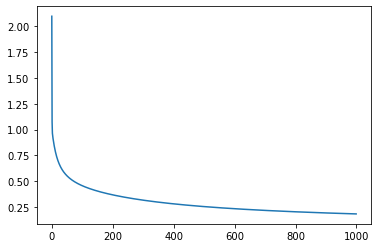

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(log.loss)), log.loss)

In [17]:
x = X_train[0].reshape((1, 4))
y = np.array([0, 1, 0]).reshape((1,3))
w = np.random.random((4, 3))

In [18]:
x, y, w

(array([[5.7, 2.9, 4.2, 1.3]]),
 array([[0, 1, 0]]),
 array([[0.89345504, 0.7271838 , 0.42939159],
        [0.25165296, 0.61925503, 0.38938986],
        [0.28155611, 0.98284036, 0.33062711],
        [0.55106762, 0.91871437, 0.59171374]]))

In [21]:
z = x.dot(w)
z = np.exp(z) / np.sum(np.exp(z))
z

array([[0.02804228, 0.96811213, 0.00384559]])

In [26]:
np.sum(z)

0.9999999999999999

In [25]:
x.T.dot((y - z))

array([[-0.15984099,  0.18176085, -0.02191986],
       [-0.08132261,  0.09247482, -0.01115221],
       [-0.11777757,  0.13392905, -0.01615147],
       [-0.03645496,  0.04145423, -0.00499927]])